In [1]:
import keras
from keras.models import Sequential
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
import pickle

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [05:03<00:00, 139.81it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(42378, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [01:22<00:00, 107.09it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(8803, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    21189
class       51
dtype: int64
image    8803
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
base_model = NASNetMobile(include_top=False, weights='imagenet')

In [11]:
print(base_model.output_shape)

(None, 7, 7, 1056)


In [12]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

separable_conv_2_reduction_righ (None, 56, 56, 11)   396         activation_9[0][0]               
__________________________________________________________________________________________________
separable_conv_2_reduction_left (None, 56, 56, 11)   220         activation_11[0][0]              
__________________________________________________________________________________________________
adjust_relu_1_stem_2 (Activatio (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_add_2_stem_1 (Add)    (None, 56, 56, 11)   0           reduction_left2_stem_1[0][0]     
                                                                 separable_conv_2_bn_reduction_rig
__________________________________________________________________________________________________
reduction_left3_stem_1 (Average (None, 56, 56, 11)   0           reduction_pad_1_stem_1[0][0]     
__________

separable_conv_2_bn_reduction_l (None, 28, 28, 22)   88          separable_conv_2_reduction_left1_
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 28, 28, 22)   88          separable_conv_2_reduction_right1
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 61, 61, 22)   0           activation_17[0][0]              
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 56, 56, 22)   0           adjust_bn_stem_2[0][0]           
__________________________________________________________________________________________________
reduction_add_1_stem_2 (Add)    (None, 28, 28, 22)   0           separable_conv_2_bn_reduction_lef
                                                                 separable_conv_2_bn_reduction_rig
__________

adjust_conv_1_0 (Conv2D)        (None, 28, 28, 22)   968         adjust_avg_pool_1_0[0][0]        
__________________________________________________________________________________________________
adjust_conv_2_0 (Conv2D)        (None, 28, 28, 22)   968         adjust_avg_pool_2_0[0][0]        
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 28, 28, 88)   0           reduction_concat_stem_2[0][0]    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 28, 28, 44)   0           adjust_conv_1_0[0][0]            
                                                                 adjust_conv_2_0[0][0]            
__________________________________________________________________________________________________
normal_conv_1_0 (Conv2D)        (None, 28, 28, 44)   3872        activation_23[0][0]              
__________

                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_0 (Add)            (None, 28, 28, 44)   0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_0 (Add)            (None, 28, 28, 44)   0           normal_left3_0[0][0]             
                                                                 adjust_bn_0[0][0]                
__________________________________________________________________________________________________
normal_add_4_0 (Add)            (None, 28, 28, 44)   0           normal_left4_0[0][0]             
                                                                 normal_right4_0[0][0]            
__________

__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left1_1[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right1_1[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 28, 28, 44)   176         separable_conv_2_normal_left2_1[0
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_2_normal_right2_1[
__________________________________________________________________________________________________
normal_left3_1 (AveragePooling2 (None, 28, 28, 44)   0           normal_bn_1_1[0][0]              
__________

__________________________________________________________________________________________________
activation_51 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_right1
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_left2_
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 28, 28, 44)   0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_2 (None, 28, 28, 44)   3036        activation_49[0][0]              
__________

__________________________________________________________________________________________________
separable_conv_1_normal_left2_3 (None, 28, 28, 44)   3036        activation_64[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 28, 28, 44)   2332        activation_66[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left5_3 (None, 28, 28, 44)   2332        activation_68[0][0]              
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 28, 28, 44)   176         separable_conv_1_normal_left1_3[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 28, 28, 44)   176         separable_conv_1_normal_right1_3[
__________

__________________________________________________________________________________________________
reduction_bn_1_reduce_4 (BatchN (None, 28, 28, 88)   352         reduction_conv_1_reduce_4[0][0]  
__________________________________________________________________________________________________
adjust_bn_reduce_4 (BatchNormal (None, 28, 28, 88)   352         adjust_conv_projection_reduce_4[0
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 28, 28, 88)   0           reduction_bn_1_reduce_4[0][0]    
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 28, 28, 88)   0           adjust_bn_reduce_4[0][0]         
__________________________________________________________________________________________________
separable_conv_1_pad_reduction_ (None, 31, 31, 88)   0           activation_72[0][0]              
__________

__________________________________________________________________________________________________
separable_conv_2_bn_reduction_r (None, 14, 14, 88)   352         separable_conv_2_reduction_right3
__________________________________________________________________________________________________
reduction_left4_reduce_4 (Avera (None, 14, 14, 88)   0           reduction_add_1_reduce_4[0][0]   
__________________________________________________________________________________________________
separable_conv_2_bn_reduction_l (None, 14, 14, 88)   352         separable_conv_2_reduction_left4_
__________________________________________________________________________________________________
reduction_right5_reduce_4 (MaxP (None, 14, 14, 88)   0           reduction_pad_1_reduce_4[0][0]   
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 29, 29, 264)  0           adjust_relu_1_5[0][0]            
__________

activation_90 (Activation)      (None, 14, 14, 88)   0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_92 (Activation)      (None, 14, 14, 88)   0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_5 (None, 14, 14, 88)   9944        activation_84[0][0]              
__________________________________________________________________________________________________
separable_conv_2_normal_right1_ (None, 14, 14, 88)   8536        activation_86[0][0]              
__________________________________________________________________________________________________
separable_conv_2_normal_left2_5 (None, 14, 14, 88)   9944        activation_88[0][0]              
__________________________________________________________________________________________________
separable_

separable_conv_1_normal_left5_6 (None, 14, 14, 88)   8536        activation_103[0][0]             
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left1_6[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right1_6[
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 14, 14, 88)   352         separable_conv_1_normal_left2_6[0
__________________________________________________________________________________________________
separable_conv_1_bn_normal_righ (None, 14, 14, 88)   352         separable_conv_1_normal_right2_6[
__________________________________________________________________________________________________
separable_

activation_107 (Activation)     (None, 14, 14, 88)   0           normal_bn_1_7[0][0]              
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_113 (Activation)     (None, 14, 14, 88)   0           adjust_bn_7[0][0]                
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 14, 14, 88)   0           normal_bn_1_7[0][0]              
__________________________________________________________________________________________________
separable_

                                                                 normal_add_1_7[0][0]             
                                                                 normal_add_2_7[0][0]             
                                                                 normal_add_3_7[0][0]             
                                                                 normal_add_4_7[0][0]             
                                                                 normal_add_5_7[0][0]             
__________________________________________________________________________________________________
activation_117 (Activation)     (None, 14, 14, 528)  0           normal_concat_6[0][0]            
__________________________________________________________________________________________________
activation_118 (Activation)     (None, 14, 14, 528)  0           normal_concat_7[0][0]            
__________________________________________________________________________________________________
adjust_con

separable_conv_2_bn_normal_left (None, 14, 14, 88)   352         separable_conv_2_normal_left5_8[0
__________________________________________________________________________________________________
normal_add_1_8 (Add)            (None, 14, 14, 88)   0           separable_conv_2_bn_normal_left1_
                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_8 (Add)            (None, 14, 14, 88)   0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_8 (Add)            (None, 14, 14, 88)   0           normal_left3_8[0][0]             
                                                                 adjust_bn_8[0][0]                
__________

__________________________________________________________________________________________________
separable_conv_1_reduction_left (None, 7, 7, 176)    32560       activation_139[0][0]             
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_reduction_rig
__________________________________________________________________________________________________
separable_conv_1_bn_reduction_r (None, 7, 7, 176)    704         separable_conv_1_reduction_right3
__________________________________________________________________________________________________
separable_conv_1_bn_reduction_l (None, 7, 7, 176)    704         separable_conv_1_reduction_left4_
__________________________________________________________________________________________________
reduction_pad_1_reduce_8 (ZeroP (None, 15, 15, 176)  0           reduction_bn_1_reduce_8[0][0]    
__________

__________________________________________________________________________________________________
activation_148 (Activation)     (None, 7, 7, 176)    0           adjust_bn_9[0][0]                
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 7, 7, 176)    0           normal_bn_1_9[0][0]              
__________________________________________________________________________________________________
separable_conv_1_normal_left1_9 (None, 7, 7, 176)    35376       activation_142[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 7, 7, 176)    32560       activation_144[0][0]             
__________________________________________________________________________________________________
separable_conv_1_normal_left2_9 (None, 7, 7, 176)    35376       activation_146[0][0]             
__________

__________________________________________________________________________________________________
activation_152 (Activation)     (None, 7, 7, 704)    0           reduction_concat_reduce_8[0][0]  
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 7, 7, 1056)   0           normal_concat_9[0][0]            
__________________________________________________________________________________________________
adjust_conv_projection_10 (Conv (None, 7, 7, 176)    123904      activation_152[0][0]             
__________________________________________________________________________________________________
normal_conv_1_10 (Conv2D)       (None, 7, 7, 176)    185856      activation_153[0][0]             
__________________________________________________________________________________________________
adjust_bn_10 (BatchNormalizatio (None, 7, 7, 176)    704         adjust_conv_projection_10[0][0]  
__________

normal_add_2_10 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_10 (Add)           (None, 7, 7, 176)    0           normal_left3_10[0][0]            
                                                                 adjust_bn_10[0][0]               
__________________________________________________________________________________________________
normal_add_4_10 (Add)           (None, 7, 7, 176)    0           normal_left4_10[0][0]            
                                                                 normal_right4_10[0][0]           
__________________________________________________________________________________________________
normal_add_5_10 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left5_
          

__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_2_normal_right1_11
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 7, 7, 176)    704         separable_conv_2_normal_left2_11[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 7, 7, 176)    704         separable_conv_2_normal_right2_11
__________________________________________________________________________________________________
normal_left3_11 (AveragePooling (None, 7, 7, 176)    0           normal_bn_1_11[0][0]             
__________________________________________________________________________________________________
normal_left4_11 (AveragePooling (None, 7, 7, 176)    0           adjust_bn_11[0][0]               
__________

__________________________________________________________________________________________________
activation_183 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_left2_
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_right2
__________________________________________________________________________________________________
activation_187 (Activation)     (None, 7, 7, 176)    0           separable_conv_1_bn_normal_left5_
__________________________________________________________________________________________________
separable_conv_2_normal_left1_1 (None, 7, 7, 176)    35376       activation_179[0][0]             
__________________________________________________________________________________________________
separable_conv_2_normal_right1_ (None, 7, 7, 176)    32560       activation_181[0][0]             
__________

In [13]:
base_model.get_config()

{'name': 'NASNet',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'stem_conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'stem_conv1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 2.0,
      'mode': 'fan_in',
      'distribution': 'normal',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_1', 0,

In [14]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

2020-10-01 21:12:13.554892
(42378, 7, 7, 1056)
1:28:21.292371


In [15]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(42378, 7*7*1056)

In [16]:
pickle_out = open('../Pickle/NASNetMobile_X_train_OF.pickle',"wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

In [17]:
pickle_in = open('../Pickle/NASNetMobile_X_train_OF.pickle',"rb")
X_train = pickle.load(pickle_in)
print(X_train.shape)

(42378, 51744)


In [18]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4-t3)

2020-10-01 22:43:20.411402
(8803, 7, 7, 1056)
0:17:51.562199


In [19]:
X_test = X_test.reshape(8803, 7*7*1056)

In [20]:
pickle_out = open('../Pickle/NASNetMobile_X_test_OF.pickle',"wb")
pickle.dump(X_test, pickle_out, protocol=4)
pickle_out.close()

In [21]:
pickle_in = open('../Pickle/NASNetMobile_X_test_OF.pickle',"rb")
X_test = pickle.load(pickle_in)
print(X_test.shape)

(8803, 51744)


In [22]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 51744)
(8803, 51744)
(42378, 51)
(8803, 51)


In [30]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51744,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [31]:
model.output_shape

(None, 51)

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              52986880  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [33]:
model.get_config()

{'name': 'sequential_2',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_6',
    'trainable': True,
    'batch_input_shape': (None, 51744),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_5',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_7',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [34]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightNASNetMobile_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [35]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [36]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6-t5)

2020-10-01 23:02:57.477050
Train on 42378 samples, validate on 8803 samples
Epoch 1/100


23424/42378 [===============>..............] - ETA: 11:26 - loss: 5.8352 - accuracy: 0.015 - ETA: 7:32 - loss: 10.9095 - accuracy: 0.023 - ETA: 6:11 - loss: 12.1886 - accuracy: 0.020 - ETA: 5:29 - loss: 12.7638 - accuracy: 0.021 - ETA: 5:01 - loss: 12.7048 - accuracy: 0.023 - ETA: 4:42 - loss: 12.4716 - accuracy: 0.020 - ETA: 4:29 - loss: 12.0598 - accuracy: 0.024 - ETA: 4:18 - loss: 11.6482 - accuracy: 0.022 - ETA: 4:10 - loss: 11.1511 - accuracy: 0.022 - ETA: 4:04 - loss: 10.7033 - accuracy: 0.025 - ETA: 3:59 - loss: 10.2995 - accuracy: 0.026 - ETA: 3:54 - loss: 9.9270 - accuracy: 0.027 - ETA: 3:50 - loss: 9.5818 - accuracy: 0.02 - ETA: 3:46 - loss: 9.2822 - accuracy: 0.02 - ETA: 3:43 - loss: 9.0130 - accuracy: 0.02 - ETA: 3:40 - loss: 8.7548 - accuracy: 0.02 - ETA: 3:38 - loss: 8.5013 - accuracy: 0.02 - ETA: 3:35 - loss: 8.2702 - accuracy: 0.02 - ETA: 3:33 - loss: 8.0628 - accuracy: 0.02 - ETA: 3:31 - loss: 7.8757 - accuracy: 0.02 - ETA: 3:29 - loss: 7.7073 - accuracy: 0.02 - ETA: 3

42378/42378 [==============================] - ETA: 1:33 - loss: 4.3706 - accuracy: 0.03 - ETA: 1:32 - loss: 4.3682 - accuracy: 0.03 - ETA: 1:32 - loss: 4.3656 - accuracy: 0.03 - ETA: 1:31 - loss: 4.3631 - accuracy: 0.03 - ETA: 1:30 - loss: 4.3607 - accuracy: 0.03 - ETA: 1:30 - loss: 4.3585 - accuracy: 0.03 - ETA: 1:29 - loss: 4.3561 - accuracy: 0.03 - ETA: 1:29 - loss: 4.3534 - accuracy: 0.03 - ETA: 1:28 - loss: 4.3512 - accuracy: 0.03 - ETA: 1:27 - loss: 4.3488 - accuracy: 0.03 - ETA: 1:27 - loss: 4.3467 - accuracy: 0.03 - ETA: 1:26 - loss: 4.3444 - accuracy: 0.03 - ETA: 1:25 - loss: 4.3423 - accuracy: 0.03 - ETA: 1:25 - loss: 4.3392 - accuracy: 0.03 - ETA: 1:24 - loss: 4.3373 - accuracy: 0.03 - ETA: 1:23 - loss: 4.3354 - accuracy: 0.03 - ETA: 1:23 - loss: 4.3330 - accuracy: 0.03 - ETA: 1:22 - loss: 4.3308 - accuracy: 0.03 - ETA: 1:21 - loss: 4.3284 - accuracy: 0.03 - ETA: 1:21 - loss: 4.3263 - accuracy: 0.03 - ETA: 1:20 - loss: 4.3244 - accuracy: 0.03 - ETA: 1:19 - loss: 4.3222 - ac

23808/42378 [===============>..............] - ETA: 3:52 - loss: 3.8536 - accuracy: 0.03 - ETA: 3:35 - loss: 3.8567 - accuracy: 0.02 - ETA: 3:31 - loss: 3.8231 - accuracy: 0.04 - ETA: 3:31 - loss: 3.8370 - accuracy: 0.04 - ETA: 3:27 - loss: 3.8451 - accuracy: 0.04 - ETA: 3:26 - loss: 3.8493 - accuracy: 0.04 - ETA: 3:23 - loss: 3.8490 - accuracy: 0.04 - ETA: 3:22 - loss: 3.8558 - accuracy: 0.05 - ETA: 3:21 - loss: 3.8546 - accuracy: 0.04 - ETA: 3:20 - loss: 3.8500 - accuracy: 0.04 - ETA: 3:18 - loss: 3.8525 - accuracy: 0.05 - ETA: 3:17 - loss: 3.8534 - accuracy: 0.05 - ETA: 3:16 - loss: 3.8511 - accuracy: 0.04 - ETA: 3:15 - loss: 3.8459 - accuracy: 0.04 - ETA: 3:14 - loss: 3.8437 - accuracy: 0.04 - ETA: 3:15 - loss: 3.8394 - accuracy: 0.05 - ETA: 3:15 - loss: 3.8375 - accuracy: 0.05 - ETA: 3:15 - loss: 3.8308 - accuracy: 0.05 - ETA: 3:14 - loss: 3.8316 - accuracy: 0.05 - ETA: 3:13 - loss: 3.8320 - accuracy: 0.05 - ETA: 3:12 - loss: 3.8303 - accuracy: 0.05 - ETA: 3:12 - loss: 3.8311 - ac

42378/42378 [==============================] - ETA: 1:28 - loss: 3.8004 - accuracy: 0.05 - ETA: 1:27 - loss: 3.8005 - accuracy: 0.05 - ETA: 1:27 - loss: 3.8000 - accuracy: 0.05 - ETA: 1:26 - loss: 3.8003 - accuracy: 0.05 - ETA: 1:26 - loss: 3.8001 - accuracy: 0.05 - ETA: 1:25 - loss: 3.7997 - accuracy: 0.06 - ETA: 1:24 - loss: 3.7992 - accuracy: 0.06 - ETA: 1:24 - loss: 3.7995 - accuracy: 0.06 - ETA: 1:23 - loss: 3.7990 - accuracy: 0.06 - ETA: 1:23 - loss: 3.7989 - accuracy: 0.06 - ETA: 1:22 - loss: 3.7985 - accuracy: 0.06 - ETA: 1:21 - loss: 3.7983 - accuracy: 0.06 - ETA: 1:21 - loss: 3.7982 - accuracy: 0.06 - ETA: 1:20 - loss: 3.7978 - accuracy: 0.06 - ETA: 1:19 - loss: 3.7974 - accuracy: 0.06 - ETA: 1:19 - loss: 3.7974 - accuracy: 0.06 - ETA: 1:18 - loss: 3.7970 - accuracy: 0.06 - ETA: 1:17 - loss: 3.7965 - accuracy: 0.06 - ETA: 1:17 - loss: 3.7963 - accuracy: 0.06 - ETA: 1:16 - loss: 3.7956 - accuracy: 0.06 - ETA: 1:16 - loss: 3.7955 - accuracy: 0.06 - ETA: 1:15 - loss: 3.7958 - ac

23808/42378 [===============>..............] - ETA: 3:08 - loss: 3.7722 - accuracy: 0.10 - ETA: 3:07 - loss: 3.7197 - accuracy: 0.10 - ETA: 3:08 - loss: 3.7546 - accuracy: 0.08 - ETA: 3:09 - loss: 3.7194 - accuracy: 0.09 - ETA: 3:12 - loss: 3.7201 - accuracy: 0.08 - ETA: 3:11 - loss: 3.7285 - accuracy: 0.08 - ETA: 3:11 - loss: 3.7404 - accuracy: 0.07 - ETA: 3:11 - loss: 3.7393 - accuracy: 0.07 - ETA: 3:11 - loss: 3.7469 - accuracy: 0.07 - ETA: 3:11 - loss: 3.7436 - accuracy: 0.07 - ETA: 3:10 - loss: 3.7419 - accuracy: 0.07 - ETA: 3:09 - loss: 3.7457 - accuracy: 0.07 - ETA: 3:08 - loss: 3.7433 - accuracy: 0.07 - ETA: 3:08 - loss: 3.7393 - accuracy: 0.07 - ETA: 3:08 - loss: 3.7405 - accuracy: 0.07 - ETA: 3:08 - loss: 3.7393 - accuracy: 0.07 - ETA: 3:08 - loss: 3.7355 - accuracy: 0.07 - ETA: 3:06 - loss: 3.7374 - accuracy: 0.07 - ETA: 3:06 - loss: 3.7394 - accuracy: 0.07 - ETA: 3:05 - loss: 3.7432 - accuracy: 0.07 - ETA: 3:04 - loss: 3.7458 - accuracy: 0.07 - ETA: 3:03 - loss: 3.7418 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.7139 - accuracy: 0.07 - ETA: 1:24 - loss: 3.7135 - accuracy: 0.07 - ETA: 1:23 - loss: 3.7129 - accuracy: 0.07 - ETA: 1:22 - loss: 3.7130 - accuracy: 0.07 - ETA: 1:22 - loss: 3.7124 - accuracy: 0.07 - ETA: 1:21 - loss: 3.7121 - accuracy: 0.07 - ETA: 1:21 - loss: 3.7116 - accuracy: 0.07 - ETA: 1:20 - loss: 3.7109 - accuracy: 0.07 - ETA: 1:19 - loss: 3.7113 - accuracy: 0.07 - ETA: 1:19 - loss: 3.7113 - accuracy: 0.07 - ETA: 1:18 - loss: 3.7108 - accuracy: 0.07 - ETA: 1:18 - loss: 3.7109 - accuracy: 0.07 - ETA: 1:17 - loss: 3.7109 - accuracy: 0.07 - ETA: 1:17 - loss: 3.7111 - accuracy: 0.07 - ETA: 1:16 - loss: 3.7102 - accuracy: 0.07 - ETA: 1:15 - loss: 3.7098 - accuracy: 0.07 - ETA: 1:15 - loss: 3.7095 - accuracy: 0.07 - ETA: 1:14 - loss: 3.7093 - accuracy: 0.07 - ETA: 1:14 - loss: 3.7092 - accuracy: 0.07 - ETA: 1:13 - loss: 3.7090 - accuracy: 0.07 - ETA: 1:12 - loss: 3.7085 - accuracy: 0.07 - ETA: 1:12 - loss: 3.7081 - ac

23808/42378 [===============>..............] - ETA: 3:07 - loss: 3.6628 - accuracy: 0.09 - ETA: 3:04 - loss: 3.6615 - accuracy: 0.09 - ETA: 3:04 - loss: 3.6586 - accuracy: 0.09 - ETA: 3:05 - loss: 3.6569 - accuracy: 0.09 - ETA: 3:03 - loss: 3.6557 - accuracy: 0.09 - ETA: 3:02 - loss: 3.6815 - accuracy: 0.08 - ETA: 3:02 - loss: 3.6829 - accuracy: 0.08 - ETA: 3:02 - loss: 3.6928 - accuracy: 0.08 - ETA: 3:01 - loss: 3.6967 - accuracy: 0.08 - ETA: 3:01 - loss: 3.6795 - accuracy: 0.08 - ETA: 3:01 - loss: 3.6704 - accuracy: 0.08 - ETA: 3:00 - loss: 3.6705 - accuracy: 0.09 - ETA: 3:01 - loss: 3.6531 - accuracy: 0.09 - ETA: 3:02 - loss: 3.6566 - accuracy: 0.09 - ETA: 3:02 - loss: 3.6470 - accuracy: 0.09 - ETA: 3:03 - loss: 3.6401 - accuracy: 0.09 - ETA: 3:02 - loss: 3.6435 - accuracy: 0.09 - ETA: 3:01 - loss: 3.6498 - accuracy: 0.09 - ETA: 3:01 - loss: 3.6502 - accuracy: 0.09 - ETA: 3:00 - loss: 3.6489 - accuracy: 0.09 - ETA: 2:59 - loss: 3.6504 - accuracy: 0.09 - ETA: 2:59 - loss: 3.6499 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.6390 - accuracy: 0.09 - ETA: 1:23 - loss: 3.6391 - accuracy: 0.09 - ETA: 1:23 - loss: 3.6391 - accuracy: 0.09 - ETA: 1:22 - loss: 3.6389 - accuracy: 0.09 - ETA: 1:22 - loss: 3.6391 - accuracy: 0.09 - ETA: 1:21 - loss: 3.6391 - accuracy: 0.09 - ETA: 1:20 - loss: 3.6389 - accuracy: 0.09 - ETA: 1:20 - loss: 3.6384 - accuracy: 0.09 - ETA: 1:19 - loss: 3.6383 - accuracy: 0.09 - ETA: 1:19 - loss: 3.6376 - accuracy: 0.09 - ETA: 1:18 - loss: 3.6371 - accuracy: 0.09 - ETA: 1:17 - loss: 3.6381 - accuracy: 0.09 - ETA: 1:17 - loss: 3.6374 - accuracy: 0.09 - ETA: 1:16 - loss: 3.6375 - accuracy: 0.09 - ETA: 1:16 - loss: 3.6369 - accuracy: 0.09 - ETA: 1:15 - loss: 3.6363 - accuracy: 0.09 - ETA: 1:14 - loss: 3.6366 - accuracy: 0.09 - ETA: 1:14 - loss: 3.6369 - accuracy: 0.09 - ETA: 1:13 - loss: 3.6367 - accuracy: 0.09 - ETA: 1:13 - loss: 3.6366 - accuracy: 0.09 - ETA: 1:12 - loss: 3.6358 - accuracy: 0.09 - ETA: 1:12 - loss: 3.6353 - ac

23808/42378 [===============>..............] - ETA: 3:13 - loss: 3.6400 - accuracy: 0.10 - ETA: 3:08 - loss: 3.6471 - accuracy: 0.08 - ETA: 3:07 - loss: 3.6630 - accuracy: 0.08 - ETA: 3:06 - loss: 3.6230 - accuracy: 0.09 - ETA: 3:07 - loss: 3.6134 - accuracy: 0.09 - ETA: 3:08 - loss: 3.6023 - accuracy: 0.09 - ETA: 3:09 - loss: 3.5938 - accuracy: 0.09 - ETA: 3:11 - loss: 3.6314 - accuracy: 0.08 - ETA: 3:10 - loss: 3.6367 - accuracy: 0.08 - ETA: 3:09 - loss: 3.6475 - accuracy: 0.08 - ETA: 3:08 - loss: 3.6333 - accuracy: 0.08 - ETA: 3:06 - loss: 3.6300 - accuracy: 0.08 - ETA: 3:05 - loss: 3.6172 - accuracy: 0.09 - ETA: 3:05 - loss: 3.6174 - accuracy: 0.08 - ETA: 3:05 - loss: 3.6185 - accuracy: 0.08 - ETA: 3:05 - loss: 3.6229 - accuracy: 0.08 - ETA: 3:05 - loss: 3.6224 - accuracy: 0.08 - ETA: 3:04 - loss: 3.6307 - accuracy: 0.08 - ETA: 3:04 - loss: 3.6325 - accuracy: 0.08 - ETA: 3:03 - loss: 3.6321 - accuracy: 0.08 - ETA: 3:02 - loss: 3.6321 - accuracy: 0.08 - ETA: 3:02 - loss: 3.6267 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.5808 - accuracy: 0.09 - ETA: 1:24 - loss: 3.5810 - accuracy: 0.09 - ETA: 1:23 - loss: 3.5806 - accuracy: 0.09 - ETA: 1:22 - loss: 3.5809 - accuracy: 0.09 - ETA: 1:22 - loss: 3.5813 - accuracy: 0.09 - ETA: 1:21 - loss: 3.5821 - accuracy: 0.09 - ETA: 1:21 - loss: 3.5816 - accuracy: 0.09 - ETA: 1:20 - loss: 3.5811 - accuracy: 0.09 - ETA: 1:19 - loss: 3.5810 - accuracy: 0.09 - ETA: 1:19 - loss: 3.5809 - accuracy: 0.09 - ETA: 1:18 - loss: 3.5807 - accuracy: 0.09 - ETA: 1:18 - loss: 3.5803 - accuracy: 0.09 - ETA: 1:17 - loss: 3.5790 - accuracy: 0.09 - ETA: 1:17 - loss: 3.5782 - accuracy: 0.09 - ETA: 1:16 - loss: 3.5780 - accuracy: 0.09 - ETA: 1:15 - loss: 3.5784 - accuracy: 0.09 - ETA: 1:15 - loss: 3.5790 - accuracy: 0.09 - ETA: 1:14 - loss: 3.5790 - accuracy: 0.09 - ETA: 1:14 - loss: 3.5798 - accuracy: 0.09 - ETA: 1:13 - loss: 3.5799 - accuracy: 0.09 - ETA: 1:12 - loss: 3.5802 - accuracy: 0.09 - ETA: 1:12 - loss: 3.5801 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.7114 - accuracy: 0.09 - ETA: 5:09 - loss: 3.7004 - accuracy: 0.07 - ETA: 5:10 - loss: 3.5873 - accuracy: 0.10 - ETA: 5:08 - loss: 3.6097 - accuracy: 0.11 - ETA: 5:04 - loss: 3.5913 - accuracy: 0.11 - ETA: 5:02 - loss: 3.6156 - accuracy: 0.10 - ETA: 5:02 - loss: 3.5972 - accuracy: 0.10 - ETA: 5:00 - loss: 3.6049 - accuracy: 0.10 - ETA: 5:00 - loss: 3.6000 - accuracy: 0.10 - ETA: 5:01 - loss: 3.6038 - accuracy: 0.10 - ETA: 5:01 - loss: 3.6153 - accuracy: 0.10 - ETA: 5:01 - loss: 3.6165 - accuracy: 0.09 - ETA: 5:01 - loss: 3.6171 - accuracy: 0.09 - ETA: 5:02 - loss: 3.6106 - accuracy: 0.10 - ETA: 5:03 - loss: 3.6120 - accuracy: 0.10 - ETA: 5:02 - loss: 3.6117 - accuracy: 0.10 - ETA: 5:08 - loss: 3.5958 - accuracy: 0.10 - ETA: 5:08 - loss: 3.5943 - accuracy: 0.10 - ETA: 5:03 - loss: 3.5948 - accuracy: 0.10 - ETA: 4:57 - loss: 3.5923 - accuracy: 0.10 - ETA: 4:51 - loss: 3.5998 - accuracy: 0.10 - ETA: 4:45 - loss: 3.6012 - ac

42378/42378 [==============================] - ETA: 1:29 - loss: 3.5391 - accuracy: 0.10 - ETA: 1:29 - loss: 3.5378 - accuracy: 0.10 - ETA: 1:28 - loss: 3.5384 - accuracy: 0.10 - ETA: 1:27 - loss: 3.5379 - accuracy: 0.10 - ETA: 1:27 - loss: 3.5377 - accuracy: 0.10 - ETA: 1:26 - loss: 3.5388 - accuracy: 0.10 - ETA: 1:25 - loss: 3.5387 - accuracy: 0.10 - ETA: 1:25 - loss: 3.5398 - accuracy: 0.10 - ETA: 1:24 - loss: 3.5395 - accuracy: 0.10 - ETA: 1:23 - loss: 3.5400 - accuracy: 0.10 - ETA: 1:23 - loss: 3.5396 - accuracy: 0.10 - ETA: 1:22 - loss: 3.5395 - accuracy: 0.10 - ETA: 1:22 - loss: 3.5394 - accuracy: 0.10 - ETA: 1:21 - loss: 3.5389 - accuracy: 0.10 - ETA: 1:20 - loss: 3.5379 - accuracy: 0.10 - ETA: 1:20 - loss: 3.5376 - accuracy: 0.10 - ETA: 1:19 - loss: 3.5367 - accuracy: 0.10 - ETA: 1:18 - loss: 3.5370 - accuracy: 0.10 - ETA: 1:18 - loss: 3.5369 - accuracy: 0.10 - ETA: 1:17 - loss: 3.5372 - accuracy: 0.10 - ETA: 1:16 - loss: 3.5361 - accuracy: 0.10 - ETA: 1:16 - loss: 3.5364 - ac

23808/42378 [===============>..............] - ETA: 3:20 - loss: 3.5171 - accuracy: 0.11 - ETA: 3:19 - loss: 3.4655 - accuracy: 0.13 - ETA: 3:20 - loss: 3.4506 - accuracy: 0.12 - ETA: 3:19 - loss: 3.4413 - accuracy: 0.12 - ETA: 3:17 - loss: 3.4390 - accuracy: 0.12 - ETA: 3:14 - loss: 3.4567 - accuracy: 0.11 - ETA: 3:11 - loss: 3.4499 - accuracy: 0.12 - ETA: 3:10 - loss: 3.4476 - accuracy: 0.12 - ETA: 3:08 - loss: 3.4707 - accuracy: 0.11 - ETA: 3:07 - loss: 3.4847 - accuracy: 0.11 - ETA: 3:07 - loss: 3.4841 - accuracy: 0.11 - ETA: 3:06 - loss: 3.4867 - accuracy: 0.11 - ETA: 3:06 - loss: 3.4861 - accuracy: 0.11 - ETA: 3:05 - loss: 3.4904 - accuracy: 0.11 - ETA: 3:04 - loss: 3.4821 - accuracy: 0.11 - ETA: 3:03 - loss: 3.4940 - accuracy: 0.11 - ETA: 3:02 - loss: 3.5014 - accuracy: 0.11 - ETA: 3:02 - loss: 3.4986 - accuracy: 0.11 - ETA: 3:01 - loss: 3.5030 - accuracy: 0.11 - ETA: 3:01 - loss: 3.4980 - accuracy: 0.11 - ETA: 3:00 - loss: 3.4967 - accuracy: 0.11 - ETA: 2:59 - loss: 3.4992 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.4895 - accuracy: 0.11 - ETA: 1:24 - loss: 3.4893 - accuracy: 0.11 - ETA: 1:23 - loss: 3.4888 - accuracy: 0.11 - ETA: 1:23 - loss: 3.4890 - accuracy: 0.11 - ETA: 1:22 - loss: 3.4895 - accuracy: 0.11 - ETA: 1:22 - loss: 3.4895 - accuracy: 0.11 - ETA: 1:21 - loss: 3.4899 - accuracy: 0.11 - ETA: 1:20 - loss: 3.4904 - accuracy: 0.11 - ETA: 1:20 - loss: 3.4905 - accuracy: 0.11 - ETA: 1:19 - loss: 3.4903 - accuracy: 0.11 - ETA: 1:19 - loss: 3.4915 - accuracy: 0.11 - ETA: 1:18 - loss: 3.4925 - accuracy: 0.11 - ETA: 1:17 - loss: 3.4924 - accuracy: 0.11 - ETA: 1:17 - loss: 3.4925 - accuracy: 0.11 - ETA: 1:16 - loss: 3.4925 - accuracy: 0.11 - ETA: 1:16 - loss: 3.4930 - accuracy: 0.11 - ETA: 1:15 - loss: 3.4936 - accuracy: 0.11 - ETA: 1:14 - loss: 3.4933 - accuracy: 0.11 - ETA: 1:14 - loss: 3.4930 - accuracy: 0.11 - ETA: 1:13 - loss: 3.4929 - accuracy: 0.11 - ETA: 1:13 - loss: 3.4930 - accuracy: 0.11 - ETA: 1:12 - loss: 3.4927 - ac

23808/42378 [===============>..............] - ETA: 3:15 - loss: 3.5242 - accuracy: 0.10 - ETA: 3:10 - loss: 3.5251 - accuracy: 0.09 - ETA: 3:08 - loss: 3.4957 - accuracy: 0.09 - ETA: 3:09 - loss: 3.4897 - accuracy: 0.10 - ETA: 3:07 - loss: 3.4856 - accuracy: 0.10 - ETA: 3:05 - loss: 3.5038 - accuracy: 0.09 - ETA: 3:05 - loss: 3.4877 - accuracy: 0.10 - ETA: 3:04 - loss: 3.4834 - accuracy: 0.10 - ETA: 3:04 - loss: 3.4682 - accuracy: 0.10 - ETA: 3:03 - loss: 3.4801 - accuracy: 0.10 - ETA: 3:03 - loss: 3.4535 - accuracy: 0.11 - ETA: 3:02 - loss: 3.4568 - accuracy: 0.11 - ETA: 3:01 - loss: 3.4502 - accuracy: 0.11 - ETA: 3:00 - loss: 3.4508 - accuracy: 0.11 - ETA: 3:00 - loss: 3.4397 - accuracy: 0.11 - ETA: 2:59 - loss: 3.4412 - accuracy: 0.11 - ETA: 2:59 - loss: 3.4491 - accuracy: 0.11 - ETA: 2:59 - loss: 3.4486 - accuracy: 0.11 - ETA: 2:58 - loss: 3.4526 - accuracy: 0.11 - ETA: 2:58 - loss: 3.4454 - accuracy: 0.11 - ETA: 2:58 - loss: 3.4443 - accuracy: 0.11 - ETA: 2:57 - loss: 3.4456 - ac

42378/42378 [==============================] - ETA: 1:26 - loss: 3.4680 - accuracy: 0.11 - ETA: 1:25 - loss: 3.4682 - accuracy: 0.11 - ETA: 1:24 - loss: 3.4681 - accuracy: 0.11 - ETA: 1:24 - loss: 3.4684 - accuracy: 0.11 - ETA: 1:23 - loss: 3.4682 - accuracy: 0.11 - ETA: 1:23 - loss: 3.4676 - accuracy: 0.11 - ETA: 1:22 - loss: 3.4667 - accuracy: 0.11 - ETA: 1:21 - loss: 3.4671 - accuracy: 0.11 - ETA: 1:21 - loss: 3.4665 - accuracy: 0.11 - ETA: 1:20 - loss: 3.4669 - accuracy: 0.11 - ETA: 1:19 - loss: 3.4676 - accuracy: 0.11 - ETA: 1:19 - loss: 3.4690 - accuracy: 0.11 - ETA: 1:18 - loss: 3.4686 - accuracy: 0.11 - ETA: 1:18 - loss: 3.4682 - accuracy: 0.11 - ETA: 1:17 - loss: 3.4680 - accuracy: 0.11 - ETA: 1:16 - loss: 3.4682 - accuracy: 0.11 - ETA: 1:16 - loss: 3.4674 - accuracy: 0.11 - ETA: 1:15 - loss: 3.4676 - accuracy: 0.11 - ETA: 1:15 - loss: 3.4673 - accuracy: 0.11 - ETA: 1:14 - loss: 3.4675 - accuracy: 0.11 - ETA: 1:13 - loss: 3.4683 - accuracy: 0.11 - ETA: 1:13 - loss: 3.4682 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 3.3023 - accuracy: 0.16 - ETA: 5:06 - loss: 3.3224 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3367 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3177 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3375 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3790 - accuracy: 0.14 - ETA: 5:03 - loss: 3.3584 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3709 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3652 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3744 - accuracy: 0.14 - ETA: 5:04 - loss: 3.3817 - accuracy: 0.14 - ETA: 5:02 - loss: 3.3821 - accuracy: 0.14 - ETA: 5:01 - loss: 3.3807 - accuracy: 0.14 - ETA: 4:59 - loss: 3.3912 - accuracy: 0.13 - ETA: 4:58 - loss: 3.3890 - accuracy: 0.13 - ETA: 4:57 - loss: 3.4060 - accuracy: 0.13 - ETA: 4:56 - loss: 3.4151 - accuracy: 0.12 - ETA: 4:55 - loss: 3.4139 - accuracy: 0.12 - ETA: 4:54 - loss: 3.4137 - accuracy: 0.12 - ETA: 4:52 - loss: 3.4132 - accuracy: 0.12 - ETA: 4:51 - loss: 3.4200 - accuracy: 0.12 - ETA: 4:50 - loss: 3.4274 - ac

42378/42378 [==============================] - ETA: 1:40 - loss: 3.4262 - accuracy: 0.12 - ETA: 1:40 - loss: 3.4269 - accuracy: 0.12 - ETA: 1:39 - loss: 3.4265 - accuracy: 0.12 - ETA: 1:38 - loss: 3.4264 - accuracy: 0.12 - ETA: 1:37 - loss: 3.4264 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4262 - accuracy: 0.12 - ETA: 1:36 - loss: 3.4269 - accuracy: 0.12 - ETA: 1:35 - loss: 3.4271 - accuracy: 0.12 - ETA: 1:34 - loss: 3.4267 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4268 - accuracy: 0.12 - ETA: 1:33 - loss: 3.4254 - accuracy: 0.12 - ETA: 1:32 - loss: 3.4252 - accuracy: 0.12 - ETA: 1:31 - loss: 3.4253 - accuracy: 0.12 - ETA: 1:30 - loss: 3.4257 - accuracy: 0.12 - ETA: 1:30 - loss: 3.4250 - accuracy: 0.12 - ETA: 1:29 - loss: 3.4251 - accuracy: 0.12 - ETA: 1:28 - loss: 3.4255 - accuracy: 0.12 - ETA: 1:27 - loss: 3.4258 - accuracy: 0.12 - ETA: 1:27 - loss: 3.4260 - accuracy: 0.12 - ETA: 1:26 - loss: 3.4252 - accuracy: 0.12 - ETA: 1:25 - loss: 3.4252 - accuracy: 0.12 - ETA: 1:24 - loss: 3.4252 - ac

23808/42378 [===============>..............] - ETA: 3:31 - loss: 3.4607 - accuracy: 0.10 - ETA: 3:16 - loss: 3.3947 - accuracy: 0.11 - ETA: 3:13 - loss: 3.4144 - accuracy: 0.11 - ETA: 3:12 - loss: 3.4414 - accuracy: 0.11 - ETA: 3:11 - loss: 3.4921 - accuracy: 0.10 - ETA: 3:10 - loss: 3.4838 - accuracy: 0.10 - ETA: 3:10 - loss: 3.4755 - accuracy: 0.10 - ETA: 3:11 - loss: 3.4662 - accuracy: 0.10 - ETA: 3:12 - loss: 3.4690 - accuracy: 0.10 - ETA: 3:13 - loss: 3.4717 - accuracy: 0.10 - ETA: 3:10 - loss: 3.4690 - accuracy: 0.10 - ETA: 3:10 - loss: 3.4617 - accuracy: 0.11 - ETA: 3:09 - loss: 3.4693 - accuracy: 0.11 - ETA: 3:08 - loss: 3.4635 - accuracy: 0.11 - ETA: 3:07 - loss: 3.4632 - accuracy: 0.11 - ETA: 3:06 - loss: 3.4701 - accuracy: 0.11 - ETA: 3:05 - loss: 3.4624 - accuracy: 0.11 - ETA: 3:05 - loss: 3.4527 - accuracy: 0.11 - ETA: 3:05 - loss: 3.4546 - accuracy: 0.11 - ETA: 3:05 - loss: 3.4506 - accuracy: 0.11 - ETA: 3:04 - loss: 3.4532 - accuracy: 0.11 - ETA: 3:03 - loss: 3.4584 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.4043 - accuracy: 0.12 - ETA: 1:24 - loss: 3.4045 - accuracy: 0.12 - ETA: 1:23 - loss: 3.4051 - accuracy: 0.12 - ETA: 1:22 - loss: 3.4049 - accuracy: 0.12 - ETA: 1:22 - loss: 3.4038 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4033 - accuracy: 0.12 - ETA: 1:21 - loss: 3.4036 - accuracy: 0.12 - ETA: 1:20 - loss: 3.4036 - accuracy: 0.12 - ETA: 1:19 - loss: 3.4032 - accuracy: 0.12 - ETA: 1:19 - loss: 3.4032 - accuracy: 0.12 - ETA: 1:18 - loss: 3.4034 - accuracy: 0.12 - ETA: 1:18 - loss: 3.4027 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4019 - accuracy: 0.12 - ETA: 1:17 - loss: 3.4016 - accuracy: 0.12 - ETA: 1:16 - loss: 3.4017 - accuracy: 0.12 - ETA: 1:15 - loss: 3.4011 - accuracy: 0.12 - ETA: 1:15 - loss: 3.4018 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4010 - accuracy: 0.12 - ETA: 1:14 - loss: 3.4015 - accuracy: 0.12 - ETA: 1:13 - loss: 3.4011 - accuracy: 0.12 - ETA: 1:12 - loss: 3.4012 - accuracy: 0.12 - ETA: 1:12 - loss: 3.4012 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 3.3558 - accuracy: 0.14 - ETA: 3:21 - loss: 3.3748 - accuracy: 0.15 - ETA: 3:21 - loss: 3.4027 - accuracy: 0.13 - ETA: 3:18 - loss: 3.3864 - accuracy: 0.12 - ETA: 3:17 - loss: 3.4161 - accuracy: 0.11 - ETA: 3:15 - loss: 3.3950 - accuracy: 0.11 - ETA: 3:14 - loss: 3.3955 - accuracy: 0.12 - ETA: 3:13 - loss: 3.3887 - accuracy: 0.12 - ETA: 3:12 - loss: 3.3937 - accuracy: 0.12 - ETA: 3:12 - loss: 3.3710 - accuracy: 0.12 - ETA: 3:12 - loss: 3.3479 - accuracy: 0.12 - ETA: 3:13 - loss: 3.3521 - accuracy: 0.12 - ETA: 3:13 - loss: 3.3494 - accuracy: 0.12 - ETA: 3:12 - loss: 3.3491 - accuracy: 0.13 - ETA: 3:11 - loss: 3.3485 - accuracy: 0.13 - ETA: 3:09 - loss: 3.3421 - accuracy: 0.13 - ETA: 3:08 - loss: 3.3464 - accuracy: 0.13 - ETA: 3:07 - loss: 3.3478 - accuracy: 0.12 - ETA: 3:06 - loss: 3.3516 - accuracy: 0.12 - ETA: 3:05 - loss: 3.3495 - accuracy: 0.12 - ETA: 3:05 - loss: 3.3527 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3523 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.3693 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3695 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3700 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3708 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3697 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3703 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3698 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3707 - accuracy: 0.12 - ETA: 1:19 - loss: 3.3703 - accuracy: 0.12 - ETA: 1:19 - loss: 3.3696 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3692 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3697 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3698 - accuracy: 0.12 - ETA: 1:16 - loss: 3.3695 - accuracy: 0.12 - ETA: 1:16 - loss: 3.3686 - accuracy: 0.12 - ETA: 1:15 - loss: 3.3679 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3670 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3666 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3668 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3672 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3672 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3671 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.2167 - accuracy: 0.15 - ETA: 3:16 - loss: 3.2106 - accuracy: 0.14 - ETA: 3:12 - loss: 3.2552 - accuracy: 0.13 - ETA: 3:09 - loss: 3.3174 - accuracy: 0.12 - ETA: 3:07 - loss: 3.3092 - accuracy: 0.12 - ETA: 3:06 - loss: 3.3187 - accuracy: 0.13 - ETA: 3:05 - loss: 3.3012 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3293 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3193 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3275 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3265 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3275 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3325 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3263 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3373 - accuracy: 0.12 - ETA: 3:04 - loss: 3.3310 - accuracy: 0.12 - ETA: 3:04 - loss: 3.3357 - accuracy: 0.12 - ETA: 3:03 - loss: 3.3408 - accuracy: 0.12 - ETA: 3:02 - loss: 3.3495 - accuracy: 0.12 - ETA: 3:02 - loss: 3.3436 - accuracy: 0.12 - ETA: 3:01 - loss: 3.3458 - accuracy: 0.12 - ETA: 3:00 - loss: 3.3402 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.3405 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3404 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3399 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3407 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3404 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3401 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3401 - accuracy: 0.12 - ETA: 1:20 - loss: 3.3409 - accuracy: 0.12 - ETA: 1:19 - loss: 3.3408 - accuracy: 0.12 - ETA: 1:18 - loss: 3.3414 - accuracy: 0.12 - ETA: 1:18 - loss: 3.3408 - accuracy: 0.12 - ETA: 1:17 - loss: 3.3417 - accuracy: 0.12 - ETA: 1:17 - loss: 3.3414 - accuracy: 0.12 - ETA: 1:16 - loss: 3.3414 - accuracy: 0.12 - ETA: 1:16 - loss: 3.3413 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3416 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3418 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3418 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3425 - accuracy: 0.12 - ETA: 1:13 - loss: 3.3421 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3414 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3415 - ac

23808/42378 [===============>..............] - ETA: 3:24 - loss: 3.2848 - accuracy: 0.14 - ETA: 3:12 - loss: 3.3097 - accuracy: 0.14 - ETA: 3:14 - loss: 3.3045 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3133 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3176 - accuracy: 0.14 - ETA: 3:09 - loss: 3.3022 - accuracy: 0.15 - ETA: 3:09 - loss: 3.3010 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3056 - accuracy: 0.13 - ETA: 3:08 - loss: 3.2879 - accuracy: 0.13 - ETA: 3:08 - loss: 3.2822 - accuracy: 0.13 - ETA: 3:07 - loss: 3.2862 - accuracy: 0.13 - ETA: 3:06 - loss: 3.2853 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2859 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2923 - accuracy: 0.13 - ETA: 3:04 - loss: 3.2856 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3006 - accuracy: 0.13 - ETA: 3:05 - loss: 3.2959 - accuracy: 0.13 - ETA: 3:05 - loss: 3.3085 - accuracy: 0.13 - ETA: 3:05 - loss: 3.3139 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3136 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3109 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3102 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.3007 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3010 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3017 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3021 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3022 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3027 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3030 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3030 - accuracy: 0.13 - ETA: 1:19 - loss: 3.3031 - accuracy: 0.13 - ETA: 1:19 - loss: 3.3032 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3025 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3025 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3023 - accuracy: 0.13 - ETA: 1:16 - loss: 3.3024 - accuracy: 0.13 - ETA: 1:16 - loss: 3.3021 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3030 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3029 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3024 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3022 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3030 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3024 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3024 - ac

23808/42378 [===============>..............] - ETA: 3:43 - loss: 3.2286 - accuracy: 0.18 - ETA: 3:25 - loss: 3.3375 - accuracy: 0.14 - ETA: 3:20 - loss: 3.3689 - accuracy: 0.13 - ETA: 3:16 - loss: 3.3839 - accuracy: 0.13 - ETA: 3:13 - loss: 3.3539 - accuracy: 0.14 - ETA: 3:11 - loss: 3.3551 - accuracy: 0.14 - ETA: 3:09 - loss: 3.3420 - accuracy: 0.14 - ETA: 3:08 - loss: 3.3225 - accuracy: 0.15 - ETA: 3:07 - loss: 3.3251 - accuracy: 0.15 - ETA: 3:06 - loss: 3.3207 - accuracy: 0.14 - ETA: 3:06 - loss: 3.3126 - accuracy: 0.14 - ETA: 3:06 - loss: 3.3174 - accuracy: 0.14 - ETA: 3:06 - loss: 3.3210 - accuracy: 0.14 - ETA: 3:05 - loss: 3.3315 - accuracy: 0.14 - ETA: 3:04 - loss: 3.3378 - accuracy: 0.14 - ETA: 3:03 - loss: 3.3285 - accuracy: 0.14 - ETA: 3:02 - loss: 3.3259 - accuracy: 0.13 - ETA: 3:02 - loss: 3.3282 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3310 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3369 - accuracy: 0.13 - ETA: 3:04 - loss: 3.3278 - accuracy: 0.13 - ETA: 3:03 - loss: 3.3266 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.3105 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3104 - accuracy: 0.13 - ETA: 1:23 - loss: 3.3095 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3087 - accuracy: 0.13 - ETA: 1:22 - loss: 3.3079 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3084 - accuracy: 0.13 - ETA: 1:21 - loss: 3.3080 - accuracy: 0.13 - ETA: 1:20 - loss: 3.3081 - accuracy: 0.13 - ETA: 1:19 - loss: 3.3081 - accuracy: 0.13 - ETA: 1:19 - loss: 3.3074 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3068 - accuracy: 0.13 - ETA: 1:18 - loss: 3.3063 - accuracy: 0.13 - ETA: 1:17 - loss: 3.3052 - accuracy: 0.13 - ETA: 1:16 - loss: 3.3045 - accuracy: 0.13 - ETA: 1:16 - loss: 3.3045 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3052 - accuracy: 0.13 - ETA: 1:15 - loss: 3.3044 - accuracy: 0.13 - ETA: 1:14 - loss: 3.3054 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3049 - accuracy: 0.13 - ETA: 1:13 - loss: 3.3051 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3055 - accuracy: 0.13 - ETA: 1:12 - loss: 3.3063 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.1966 - accuracy: 0.18 - ETA: 3:16 - loss: 3.2133 - accuracy: 0.17 - ETA: 3:13 - loss: 3.2093 - accuracy: 0.17 - ETA: 3:12 - loss: 3.2407 - accuracy: 0.17 - ETA: 3:13 - loss: 3.2300 - accuracy: 0.16 - ETA: 3:13 - loss: 3.2448 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2691 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2605 - accuracy: 0.16 - ETA: 3:09 - loss: 3.2651 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2606 - accuracy: 0.16 - ETA: 3:07 - loss: 3.2578 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2522 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2764 - accuracy: 0.16 - ETA: 3:08 - loss: 3.2795 - accuracy: 0.16 - ETA: 3:08 - loss: 3.2821 - accuracy: 0.16 - ETA: 3:07 - loss: 3.2775 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2856 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2822 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2939 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2884 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2829 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2837 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.2783 - accuracy: 0.14 - ETA: 1:24 - loss: 3.2781 - accuracy: 0.14 - ETA: 1:23 - loss: 3.2789 - accuracy: 0.14 - ETA: 1:23 - loss: 3.2790 - accuracy: 0.14 - ETA: 1:22 - loss: 3.2795 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2794 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2788 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2777 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2778 - accuracy: 0.14 - ETA: 1:19 - loss: 3.2771 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2760 - accuracy: 0.14 - ETA: 1:18 - loss: 3.2754 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2746 - accuracy: 0.14 - ETA: 1:17 - loss: 3.2748 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2746 - accuracy: 0.14 - ETA: 1:16 - loss: 3.2746 - accuracy: 0.14 - ETA: 1:15 - loss: 3.2751 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2753 - accuracy: 0.14 - ETA: 1:14 - loss: 3.2754 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2757 - accuracy: 0.14 - ETA: 1:13 - loss: 3.2771 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2766 - ac

23808/42378 [===============>..............] - ETA: 3:28 - loss: 3.3487 - accuracy: 0.10 - ETA: 3:12 - loss: 3.3663 - accuracy: 0.12 - ETA: 3:10 - loss: 3.2961 - accuracy: 0.13 - ETA: 3:09 - loss: 3.2870 - accuracy: 0.13 - ETA: 3:09 - loss: 3.2633 - accuracy: 0.14 - ETA: 3:07 - loss: 3.2553 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2363 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2428 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2399 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2498 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2465 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2454 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2439 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2555 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2542 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2535 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2573 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2512 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2486 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2424 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2450 - accuracy: 0.14 - ETA: 3:00 - loss: 3.2445 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.2536 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2540 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2547 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2549 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2552 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2562 - accuracy: 0.14 - ETA: 1:21 - loss: 3.2562 - accuracy: 0.14 - ETA: 1:20 - loss: 3.2564 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2562 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2558 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2560 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2565 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2559 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2553 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2555 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2555 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2556 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2558 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2566 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2561 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2566 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2571 - ac

23808/42378 [===============>..............] - ETA: 3:30 - loss: 3.3698 - accuracy: 0.10 - ETA: 3:27 - loss: 3.3132 - accuracy: 0.17 - ETA: 3:24 - loss: 3.1694 - accuracy: 0.19 - ETA: 3:21 - loss: 3.1973 - accuracy: 0.19 - ETA: 3:19 - loss: 3.2042 - accuracy: 0.18 - ETA: 3:17 - loss: 3.1957 - accuracy: 0.18 - ETA: 3:15 - loss: 3.1997 - accuracy: 0.18 - ETA: 3:13 - loss: 3.1823 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1985 - accuracy: 0.17 - ETA: 3:11 - loss: 3.2049 - accuracy: 0.17 - ETA: 3:10 - loss: 3.2082 - accuracy: 0.16 - ETA: 3:08 - loss: 3.2147 - accuracy: 0.16 - ETA: 3:07 - loss: 3.2194 - accuracy: 0.16 - ETA: 3:06 - loss: 3.2276 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2356 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2386 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2389 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2411 - accuracy: 0.15 - ETA: 3:02 - loss: 3.2252 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2278 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2284 - accuracy: 0.15 - ETA: 2:59 - loss: 3.2268 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 3.2208 - accuracy: 0.15 - ETA: 1:25 - loss: 3.2214 - accuracy: 0.15 - ETA: 1:24 - loss: 3.2209 - accuracy: 0.15 - ETA: 1:24 - loss: 3.2205 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2206 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2204 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2207 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2218 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2225 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2227 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2222 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2219 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2222 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2224 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2218 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2215 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2203 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2196 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2195 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2203 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2198 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2206 - ac

23808/42378 [===============>..............] - ETA: 3:39 - loss: 3.3055 - accuracy: 0.15 - ETA: 3:31 - loss: 3.1906 - accuracy: 0.18 - ETA: 3:25 - loss: 3.1844 - accuracy: 0.18 - ETA: 3:23 - loss: 3.1588 - accuracy: 0.17 - ETA: 3:20 - loss: 3.1967 - accuracy: 0.16 - ETA: 3:17 - loss: 3.1939 - accuracy: 0.16 - ETA: 3:15 - loss: 3.2155 - accuracy: 0.15 - ETA: 3:13 - loss: 3.2118 - accuracy: 0.15 - ETA: 3:12 - loss: 3.2141 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2237 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2167 - accuracy: 0.16 - ETA: 3:12 - loss: 3.2100 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2127 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2370 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2381 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2391 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2343 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2355 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2361 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2376 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2315 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2306 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.2328 - accuracy: 0.15 - ETA: 1:24 - loss: 3.2322 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2315 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2310 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2314 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2300 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2310 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2314 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2312 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2304 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2302 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2304 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2310 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2296 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2298 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2294 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2294 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2282 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2277 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2280 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2269 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2267 - ac

23808/42378 [===============>..............] - ETA: 3:18 - loss: 3.1737 - accuracy: 0.18 - ETA: 3:12 - loss: 3.2235 - accuracy: 0.16 - ETA: 3:17 - loss: 3.1887 - accuracy: 0.17 - ETA: 3:20 - loss: 3.2225 - accuracy: 0.16 - ETA: 3:19 - loss: 3.2308 - accuracy: 0.17 - ETA: 3:20 - loss: 3.2617 - accuracy: 0.15 - ETA: 3:16 - loss: 3.2728 - accuracy: 0.15 - ETA: 3:15 - loss: 3.2633 - accuracy: 0.15 - ETA: 3:14 - loss: 3.2793 - accuracy: 0.14 - ETA: 3:12 - loss: 3.2794 - accuracy: 0.14 - ETA: 3:11 - loss: 3.2669 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2701 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2662 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2771 - accuracy: 0.14 - ETA: 3:08 - loss: 3.2845 - accuracy: 0.14 - ETA: 3:07 - loss: 3.2812 - accuracy: 0.14 - ETA: 3:06 - loss: 3.2828 - accuracy: 0.14 - ETA: 3:05 - loss: 3.2884 - accuracy: 0.14 - ETA: 3:04 - loss: 3.2945 - accuracy: 0.14 - ETA: 3:03 - loss: 3.2958 - accuracy: 0.14 - ETA: 3:02 - loss: 3.2777 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2739 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.2297 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2294 - accuracy: 0.15 - ETA: 1:23 - loss: 3.2298 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2295 - accuracy: 0.15 - ETA: 1:22 - loss: 3.2291 - accuracy: 0.15 - ETA: 1:21 - loss: 3.2288 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2287 - accuracy: 0.15 - ETA: 1:20 - loss: 3.2277 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2276 - accuracy: 0.15 - ETA: 1:19 - loss: 3.2279 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2271 - accuracy: 0.15 - ETA: 1:18 - loss: 3.2272 - accuracy: 0.15 - ETA: 1:17 - loss: 3.2281 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2276 - accuracy: 0.15 - ETA: 1:16 - loss: 3.2275 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2272 - accuracy: 0.15 - ETA: 1:15 - loss: 3.2274 - accuracy: 0.15 - ETA: 1:14 - loss: 3.2276 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2286 - accuracy: 0.15 - ETA: 1:13 - loss: 3.2276 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2279 - accuracy: 0.15 - ETA: 1:12 - loss: 3.2276 - ac

23808/42378 [===============>..............] - ETA: 3:21 - loss: 3.1874 - accuracy: 0.20 - ETA: 3:14 - loss: 3.2488 - accuracy: 0.17 - ETA: 3:11 - loss: 3.2950 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2757 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2173 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2212 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2055 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2085 - accuracy: 0.15 - ETA: 3:12 - loss: 3.1978 - accuracy: 0.15 - ETA: 3:11 - loss: 3.1774 - accuracy: 0.16 - ETA: 3:10 - loss: 3.2093 - accuracy: 0.16 - ETA: 3:09 - loss: 3.2165 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2189 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2141 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2025 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1916 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1926 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1827 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1856 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1880 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1807 - accuracy: 0.16 - ETA: 3:01 - loss: 3.1702 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1828 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1814 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1824 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1812 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1812 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1803 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1818 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1827 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1824 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1834 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1828 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1821 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1830 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1834 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1831 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1836 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1839 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1840 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1834 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1844 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1838 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1839 - ac

23808/42378 [===============>..............] - ETA: 3:11 - loss: 3.1326 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1805 - accuracy: 0.16 - ETA: 3:09 - loss: 3.2214 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1844 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1506 - accuracy: 0.16 - ETA: 3:06 - loss: 3.1478 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1645 - accuracy: 0.15 - ETA: 3:05 - loss: 3.1706 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1636 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1771 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1668 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1712 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1768 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1786 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1714 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1712 - accuracy: 0.15 - ETA: 3:05 - loss: 3.1784 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1843 - accuracy: 0.15 - ETA: 3:03 - loss: 3.1869 - accuracy: 0.15 - ETA: 3:03 - loss: 3.1782 - accuracy: 0.15 - ETA: 3:02 - loss: 3.1638 - accuracy: 0.15 - ETA: 3:01 - loss: 3.1678 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1783 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1784 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1783 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1779 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1783 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1778 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1773 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1776 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1772 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1776 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1767 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1760 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1766 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1765 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1770 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1763 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1775 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1782 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1773 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1780 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1779 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1776 - ac

23808/42378 [===============>..............] - ETA: 3:34 - loss: 3.2862 - accuracy: 0.12 - ETA: 3:19 - loss: 3.1105 - accuracy: 0.17 - ETA: 3:13 - loss: 3.1872 - accuracy: 0.15 - ETA: 3:11 - loss: 3.2029 - accuracy: 0.15 - ETA: 3:11 - loss: 3.1980 - accuracy: 0.15 - ETA: 3:10 - loss: 3.1808 - accuracy: 0.15 - ETA: 3:09 - loss: 3.1608 - accuracy: 0.15 - ETA: 3:08 - loss: 3.1742 - accuracy: 0.15 - ETA: 3:10 - loss: 3.1478 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1505 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1609 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1661 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1696 - accuracy: 0.15 - ETA: 3:07 - loss: 3.1739 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1732 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1629 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1655 - accuracy: 0.16 - ETA: 3:06 - loss: 3.1683 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1784 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1865 - accuracy: 0.15 - ETA: 3:03 - loss: 3.1890 - accuracy: 0.15 - ETA: 3:02 - loss: 3.1851 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 3.1637 - accuracy: 0.16 - ETA: 1:24 - loss: 3.1637 - accuracy: 0.16 - ETA: 1:24 - loss: 3.1640 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1635 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1626 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1617 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1611 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1609 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1614 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1621 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1613 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1605 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1599 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1591 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1597 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1603 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1598 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1598 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1606 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1602 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1601 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1593 - ac

23808/42378 [===============>..............] - ETA: 3:24 - loss: 3.2918 - accuracy: 0.12 - ETA: 3:13 - loss: 3.2073 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2413 - accuracy: 0.14 - ETA: 3:08 - loss: 3.2395 - accuracy: 0.14 - ETA: 3:09 - loss: 3.2327 - accuracy: 0.14 - ETA: 3:09 - loss: 3.1911 - accuracy: 0.14 - ETA: 3:09 - loss: 3.1954 - accuracy: 0.14 - ETA: 3:07 - loss: 3.1780 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1640 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1530 - accuracy: 0.15 - ETA: 3:05 - loss: 3.1668 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1554 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1351 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1391 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1349 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1331 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1302 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1348 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1355 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1337 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1331 - accuracy: 0.16 - ETA: 3:01 - loss: 3.1275 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1730 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1744 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1749 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1750 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1754 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1747 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1751 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1752 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1750 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1753 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1757 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1765 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1775 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1778 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1773 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1770 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1777 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1764 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1764 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1768 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1770 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1777 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 3.1028 - accuracy: 0.22 - ETA: 3:22 - loss: 3.1958 - accuracy: 0.18 - ETA: 3:15 - loss: 3.1603 - accuracy: 0.18 - ETA: 3:13 - loss: 3.1338 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1136 - accuracy: 0.18 - ETA: 3:10 - loss: 3.1257 - accuracy: 0.18 - ETA: 3:10 - loss: 3.1253 - accuracy: 0.18 - ETA: 3:09 - loss: 3.1093 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0925 - accuracy: 0.18 - ETA: 3:08 - loss: 3.1037 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0995 - accuracy: 0.18 - ETA: 3:07 - loss: 3.1001 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1045 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1073 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1091 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1073 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1154 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1278 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1261 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1280 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1281 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1334 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1476 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1475 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1481 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1475 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1467 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1471 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1469 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1480 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1473 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1476 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1487 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1491 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1491 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1490 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1484 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1486 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1483 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1493 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1490 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1487 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1491 - ac

23808/42378 [===============>..............] - ETA: 3:45 - loss: 3.0445 - accuracy: 0.15 - ETA: 3:32 - loss: 3.1181 - accuracy: 0.13 - ETA: 3:28 - loss: 3.1091 - accuracy: 0.15 - ETA: 3:24 - loss: 3.1297 - accuracy: 0.16 - ETA: 3:19 - loss: 3.1862 - accuracy: 0.15 - ETA: 3:18 - loss: 3.1935 - accuracy: 0.15 - ETA: 3:16 - loss: 3.1726 - accuracy: 0.15 - ETA: 3:14 - loss: 3.1500 - accuracy: 0.15 - ETA: 3:13 - loss: 3.1463 - accuracy: 0.15 - ETA: 3:11 - loss: 3.1527 - accuracy: 0.14 - ETA: 3:10 - loss: 3.1369 - accuracy: 0.15 - ETA: 3:09 - loss: 3.1369 - accuracy: 0.15 - ETA: 3:08 - loss: 3.1204 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1078 - accuracy: 0.16 - ETA: 3:06 - loss: 3.1054 - accuracy: 0.16 - ETA: 3:05 - loss: 3.0950 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0975 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0942 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1042 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1038 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1031 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1069 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1570 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1573 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1565 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1557 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1559 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1560 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1560 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1562 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1560 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1549 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1544 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1541 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1535 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1532 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1526 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1534 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1529 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1527 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1516 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1511 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1504 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1503 - ac

23808/42378 [===============>..............] - ETA: 3:28 - loss: 3.2920 - accuracy: 0.15 - ETA: 3:17 - loss: 3.1075 - accuracy: 0.17 - ETA: 3:11 - loss: 3.0594 - accuracy: 0.17 - ETA: 3:10 - loss: 3.0870 - accuracy: 0.16 - ETA: 3:10 - loss: 3.0984 - accuracy: 0.15 - ETA: 3:10 - loss: 3.0892 - accuracy: 0.15 - ETA: 3:08 - loss: 3.1160 - accuracy: 0.15 - ETA: 3:11 - loss: 3.0963 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1129 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1088 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1195 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1472 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1486 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1457 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1427 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1318 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1378 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1387 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1359 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1361 - accuracy: 0.16 - ETA: 3:01 - loss: 3.1332 - accuracy: 0.16 - ETA: 3:00 - loss: 3.1262 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1506 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1492 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1497 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1497 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1500 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1507 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1504 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1506 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1509 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1502 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1504 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1504 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1504 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1508 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1507 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1523 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1511 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1512 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1513 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1515 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1512 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1521 - ac

23808/42378 [===============>..............] - ETA: 3:44 - loss: 3.0851 - accuracy: 0.14 - ETA: 3:37 - loss: 3.1483 - accuracy: 0.15 - ETA: 3:35 - loss: 3.1486 - accuracy: 0.16 - ETA: 3:32 - loss: 3.3264 - accuracy: 0.16 - ETA: 3:28 - loss: 3.2940 - accuracy: 0.17 - ETA: 3:26 - loss: 3.2920 - accuracy: 0.16 - ETA: 3:24 - loss: 3.2742 - accuracy: 0.16 - ETA: 3:23 - loss: 3.2536 - accuracy: 0.16 - ETA: 3:22 - loss: 3.2570 - accuracy: 0.16 - ETA: 3:21 - loss: 3.2515 - accuracy: 0.16 - ETA: 3:20 - loss: 3.2445 - accuracy: 0.15 - ETA: 3:19 - loss: 3.2461 - accuracy: 0.15 - ETA: 3:18 - loss: 3.2294 - accuracy: 0.15 - ETA: 3:16 - loss: 3.2304 - accuracy: 0.15 - ETA: 3:16 - loss: 3.2317 - accuracy: 0.15 - ETA: 3:15 - loss: 3.2293 - accuracy: 0.15 - ETA: 3:13 - loss: 3.2283 - accuracy: 0.15 - ETA: 3:12 - loss: 3.2237 - accuracy: 0.16 - ETA: 3:11 - loss: 3.2268 - accuracy: 0.15 - ETA: 3:10 - loss: 3.2266 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2198 - accuracy: 0.15 - ETA: 3:08 - loss: 3.2080 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1417 - accuracy: 0.17 - ETA: 1:24 - loss: 3.1418 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1426 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1431 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1439 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1464 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1469 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1476 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1476 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1492 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1505 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1507 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1521 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1521 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1519 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1531 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1536 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1534 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1538 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1532 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1528 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1529 - ac

23808/42378 [===============>..............] - ETA: 3:42 - loss: 3.3854 - accuracy: 0.10 - ETA: 3:25 - loss: 3.2165 - accuracy: 0.16 - ETA: 3:22 - loss: 3.1882 - accuracy: 0.16 - ETA: 3:23 - loss: 3.1911 - accuracy: 0.16 - ETA: 3:23 - loss: 3.2305 - accuracy: 0.15 - ETA: 3:22 - loss: 3.1993 - accuracy: 0.15 - ETA: 3:19 - loss: 3.1929 - accuracy: 0.15 - ETA: 3:16 - loss: 3.1835 - accuracy: 0.16 - ETA: 3:15 - loss: 3.1612 - accuracy: 0.16 - ETA: 3:14 - loss: 3.1688 - accuracy: 0.16 - ETA: 3:13 - loss: 3.1539 - accuracy: 0.16 - ETA: 3:12 - loss: 3.1456 - accuracy: 0.16 - ETA: 3:10 - loss: 3.1669 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1574 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1617 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1458 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1462 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1387 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1358 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1410 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1344 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1342 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1535 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1533 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1539 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1540 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1544 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1542 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1552 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1559 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1558 - accuracy: 0.16 - ETA: 1:19 - loss: 3.1554 - accuracy: 0.16 - ETA: 1:18 - loss: 3.1560 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1564 - accuracy: 0.16 - ETA: 1:17 - loss: 3.1563 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1570 - accuracy: 0.16 - ETA: 1:16 - loss: 3.1565 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1571 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1566 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1563 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1555 - accuracy: 0.16 - ETA: 1:13 - loss: 3.1557 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1559 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1563 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 2.9898 - accuracy: 0.18 - ETA: 3:22 - loss: 3.0523 - accuracy: 0.16 - ETA: 3:15 - loss: 3.0584 - accuracy: 0.17 - ETA: 3:11 - loss: 3.0398 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0176 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0530 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0692 - accuracy: 0.17 - ETA: 3:09 - loss: 3.0635 - accuracy: 0.17 - ETA: 3:10 - loss: 3.0729 - accuracy: 0.17 - ETA: 3:11 - loss: 3.0693 - accuracy: 0.17 - ETA: 3:11 - loss: 3.0630 - accuracy: 0.17 - ETA: 3:09 - loss: 3.0750 - accuracy: 0.17 - ETA: 3:09 - loss: 3.0828 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0986 - accuracy: 0.17 - ETA: 3:06 - loss: 3.0902 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0834 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0837 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0820 - accuracy: 0.17 - ETA: 3:03 - loss: 3.0950 - accuracy: 0.17 - ETA: 3:02 - loss: 3.0992 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1100 - accuracy: 0.17 - ETA: 3:01 - loss: 3.1043 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1145 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1146 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1148 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1153 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1152 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1154 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1150 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1148 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1144 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1135 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1139 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1135 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1132 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1134 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1124 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1130 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1128 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1119 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1116 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1112 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1129 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1127 - ac

23808/42378 [===============>..............] - ETA: 3:15 - loss: 3.3965 - accuracy: 0.14 - ETA: 3:07 - loss: 3.1967 - accuracy: 0.17 - ETA: 3:06 - loss: 3.2024 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1752 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1874 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1386 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1151 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1363 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1222 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1281 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1176 - accuracy: 0.17 - ETA: 3:03 - loss: 3.0970 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1002 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0997 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0903 - accuracy: 0.18 - ETA: 3:03 - loss: 3.0873 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1010 - accuracy: 0.17 - ETA: 3:02 - loss: 3.0886 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0914 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1082 - accuracy: 0.17 - ETA: 3:00 - loss: 3.1065 - accuracy: 0.17 - ETA: 2:59 - loss: 3.1027 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1203 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1203 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1205 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1201 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1204 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1201 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1201 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1205 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1208 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1209 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1210 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1200 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1208 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1207 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1211 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1211 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1213 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1207 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1215 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1209 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1212 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1208 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.1774 - accuracy: 0.17 - ETA: 3:12 - loss: 3.1770 - accuracy: 0.17 - ETA: 3:11 - loss: 3.1461 - accuracy: 0.18 - ETA: 3:08 - loss: 3.1528 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1732 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1605 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1625 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1771 - accuracy: 0.15 - ETA: 3:06 - loss: 3.1627 - accuracy: 0.15 - ETA: 3:05 - loss: 3.1663 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1658 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1613 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1542 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1575 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1681 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1735 - accuracy: 0.15 - ETA: 3:04 - loss: 3.1623 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1620 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1509 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1441 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1343 - accuracy: 0.16 - ETA: 3:01 - loss: 3.1361 - ac

42378/42378 [==============================] - ETA: 1:25 - loss: 3.1067 - accuracy: 0.17 - ETA: 1:24 - loss: 3.1065 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1072 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1069 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1069 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1061 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1063 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1062 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1073 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1075 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1076 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1084 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1075 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1077 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1065 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1069 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1070 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1069 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1061 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1048 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1036 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1035 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 2.8540 - accuracy: 0.21 - ETA: 3:16 - loss: 2.9897 - accuracy: 0.19 - ETA: 3:13 - loss: 2.9975 - accuracy: 0.19 - ETA: 3:11 - loss: 2.9956 - accuracy: 0.19 - ETA: 3:11 - loss: 3.0216 - accuracy: 0.18 - ETA: 3:10 - loss: 3.0424 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0359 - accuracy: 0.19 - ETA: 3:07 - loss: 3.0229 - accuracy: 0.19 - ETA: 3:06 - loss: 3.0162 - accuracy: 0.19 - ETA: 3:05 - loss: 3.0244 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0201 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0333 - accuracy: 0.18 - ETA: 3:03 - loss: 3.0569 - accuracy: 0.18 - ETA: 3:03 - loss: 3.0601 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0811 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0805 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0893 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0907 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0933 - accuracy: 0.17 - ETA: 3:02 - loss: 3.0993 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0929 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0960 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1473 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1480 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1486 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1484 - accuracy: 0.16 - ETA: 1:22 - loss: 3.1482 - accuracy: 0.16 - ETA: 1:21 - loss: 3.1480 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1478 - accuracy: 0.16 - ETA: 1:20 - loss: 3.1470 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1474 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1473 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1463 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1462 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1469 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1471 - accuracy: 0.16 - ETA: 1:15 - loss: 3.1470 - accuracy: 0.16 - ETA: 1:14 - loss: 3.1455 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1451 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1444 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1444 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1450 - accuracy: 0.16 - ETA: 1:12 - loss: 3.1445 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 2.9288 - accuracy: 0.24 - ETA: 3:19 - loss: 3.0524 - accuracy: 0.21 - ETA: 3:16 - loss: 3.1754 - accuracy: 0.19 - ETA: 3:14 - loss: 3.1856 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1752 - accuracy: 0.18 - ETA: 3:09 - loss: 3.1495 - accuracy: 0.18 - ETA: 3:09 - loss: 3.1483 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1704 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1483 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1519 - accuracy: 0.17 - ETA: 3:08 - loss: 3.1373 - accuracy: 0.17 - ETA: 3:07 - loss: 3.1533 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1326 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1479 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1461 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1358 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1348 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1378 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1428 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1432 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1486 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1452 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1452 - accuracy: 0.17 - ETA: 1:24 - loss: 3.1445 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1439 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1436 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1439 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1435 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1425 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1425 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1428 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1431 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1421 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1416 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1410 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1405 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1404 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1398 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1401 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1389 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1386 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1379 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1379 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1369 - ac

23808/42378 [===============>..............] - ETA: 3:17 - loss: 3.1464 - accuracy: 0.18 - ETA: 3:15 - loss: 3.0786 - accuracy: 0.21 - ETA: 3:18 - loss: 3.1299 - accuracy: 0.19 - ETA: 3:19 - loss: 3.1416 - accuracy: 0.18 - ETA: 3:16 - loss: 3.1190 - accuracy: 0.18 - ETA: 3:15 - loss: 3.1081 - accuracy: 0.18 - ETA: 3:13 - loss: 3.1097 - accuracy: 0.17 - ETA: 3:12 - loss: 3.1079 - accuracy: 0.17 - ETA: 3:13 - loss: 3.1102 - accuracy: 0.17 - ETA: 3:14 - loss: 3.1254 - accuracy: 0.17 - ETA: 3:13 - loss: 3.1373 - accuracy: 0.16 - ETA: 3:11 - loss: 3.1497 - accuracy: 0.16 - ETA: 3:10 - loss: 3.1573 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1597 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1508 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1544 - accuracy: 0.16 - ETA: 3:06 - loss: 3.1326 - accuracy: 0.16 - ETA: 3:06 - loss: 3.1356 - accuracy: 0.16 - ETA: 3:05 - loss: 3.1326 - accuracy: 0.16 - ETA: 3:04 - loss: 3.1355 - accuracy: 0.16 - ETA: 3:03 - loss: 3.1482 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1357 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1054 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1055 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1052 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1058 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1051 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1065 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1065 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1064 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1063 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1053 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1049 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1042 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1041 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1038 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1039 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1043 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1052 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1055 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1060 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1064 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1064 - accuracy: 0.17 - ETA: 1:11 - loss: 3.1059 - ac

23808/42378 [===============>..............] - ETA: 3:23 - loss: 3.1163 - accuracy: 0.17 - ETA: 3:14 - loss: 3.0400 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1114 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0847 - accuracy: 0.18 - ETA: 3:08 - loss: 3.1224 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0934 - accuracy: 0.19 - ETA: 3:08 - loss: 3.0775 - accuracy: 0.20 - ETA: 3:06 - loss: 3.0584 - accuracy: 0.20 - ETA: 3:05 - loss: 3.0594 - accuracy: 0.19 - ETA: 3:05 - loss: 3.0628 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0768 - accuracy: 0.19 - ETA: 3:04 - loss: 3.1023 - accuracy: 0.19 - ETA: 3:03 - loss: 3.1014 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0933 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0844 - accuracy: 0.19 - ETA: 3:02 - loss: 3.0829 - accuracy: 0.19 - ETA: 3:01 - loss: 3.0834 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0900 - accuracy: 0.18 - ETA: 3:00 - loss: 3.0828 - accuracy: 0.18 - ETA: 2:59 - loss: 3.0884 - accuracy: 0.18 - ETA: 2:59 - loss: 3.0890 - accuracy: 0.18 - ETA: 2:58 - loss: 3.0801 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0993 - accuracy: 0.17 - ETA: 1:23 - loss: 3.0992 - accuracy: 0.17 - ETA: 1:23 - loss: 3.0999 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1005 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1006 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1001 - accuracy: 0.17 - ETA: 1:20 - loss: 3.0998 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1001 - accuracy: 0.17 - ETA: 1:19 - loss: 3.0997 - accuracy: 0.17 - ETA: 1:19 - loss: 3.0997 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1001 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1003 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1009 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1006 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1017 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1022 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1021 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1033 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1039 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1029 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1029 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1034 - ac

23808/42378 [===============>..............] - ETA: 3:37 - loss: 3.0381 - accuracy: 0.20 - ETA: 3:27 - loss: 3.0164 - accuracy: 0.17 - ETA: 3:27 - loss: 3.0973 - accuracy: 0.17 - ETA: 3:26 - loss: 3.0135 - accuracy: 0.18 - ETA: 3:23 - loss: 3.0637 - accuracy: 0.19 - ETA: 3:20 - loss: 3.0822 - accuracy: 0.18 - ETA: 3:18 - loss: 3.1001 - accuracy: 0.17 - ETA: 3:16 - loss: 3.0967 - accuracy: 0.18 - ETA: 3:14 - loss: 3.0882 - accuracy: 0.18 - ETA: 3:12 - loss: 3.0926 - accuracy: 0.18 - ETA: 3:11 - loss: 3.0824 - accuracy: 0.18 - ETA: 3:10 - loss: 3.0848 - accuracy: 0.18 - ETA: 3:09 - loss: 3.1040 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0881 - accuracy: 0.17 - ETA: 3:07 - loss: 3.0985 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1034 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0973 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1118 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1129 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1104 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1201 - accuracy: 0.16 - ETA: 3:02 - loss: 3.1180 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0996 - accuracy: 0.17 - ETA: 1:23 - loss: 3.0998 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1002 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1007 - accuracy: 0.17 - ETA: 1:21 - loss: 3.0999 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1005 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1009 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1003 - accuracy: 0.17 - ETA: 1:19 - loss: 3.0998 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1001 - accuracy: 0.17 - ETA: 1:18 - loss: 3.0997 - accuracy: 0.17 - ETA: 1:17 - loss: 3.0995 - accuracy: 0.17 - ETA: 1:17 - loss: 3.0998 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1007 - accuracy: 0.17 - ETA: 1:16 - loss: 3.0988 - accuracy: 0.17 - ETA: 1:15 - loss: 3.0987 - accuracy: 0.17 - ETA: 1:15 - loss: 3.0981 - accuracy: 0.17 - ETA: 1:14 - loss: 3.0976 - accuracy: 0.17 - ETA: 1:13 - loss: 3.0971 - accuracy: 0.17 - ETA: 1:13 - loss: 3.0962 - accuracy: 0.17 - ETA: 1:12 - loss: 3.0964 - accuracy: 0.17 - ETA: 1:12 - loss: 3.0968 - ac

23808/42378 [===============>..............] - ETA: 3:29 - loss: 3.2378 - accuracy: 0.14 - ETA: 3:18 - loss: 3.1526 - accuracy: 0.19 - ETA: 3:13 - loss: 3.1212 - accuracy: 0.18 - ETA: 3:13 - loss: 3.1169 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1092 - accuracy: 0.19 - ETA: 3:10 - loss: 3.0860 - accuracy: 0.19 - ETA: 3:11 - loss: 3.0900 - accuracy: 0.19 - ETA: 3:13 - loss: 3.0764 - accuracy: 0.19 - ETA: 3:13 - loss: 3.0559 - accuracy: 0.19 - ETA: 3:11 - loss: 3.0612 - accuracy: 0.19 - ETA: 3:11 - loss: 3.0697 - accuracy: 0.19 - ETA: 3:10 - loss: 3.0657 - accuracy: 0.19 - ETA: 3:09 - loss: 3.0580 - accuracy: 0.19 - ETA: 3:08 - loss: 3.0549 - accuracy: 0.19 - ETA: 3:07 - loss: 3.0534 - accuracy: 0.19 - ETA: 3:06 - loss: 3.0641 - accuracy: 0.19 - ETA: 3:05 - loss: 3.0607 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0551 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0529 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0451 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0437 - accuracy: 0.19 - ETA: 3:02 - loss: 3.0484 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0969 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0963 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0968 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0978 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0975 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0975 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0974 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0981 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0983 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0990 - accuracy: 0.17 - ETA: 1:19 - loss: 3.0991 - accuracy: 0.17 - ETA: 1:18 - loss: 3.0991 - accuracy: 0.17 - ETA: 1:18 - loss: 3.0990 - accuracy: 0.17 - ETA: 1:17 - loss: 3.0993 - accuracy: 0.17 - ETA: 1:16 - loss: 3.0994 - accuracy: 0.17 - ETA: 1:16 - loss: 3.0995 - accuracy: 0.17 - ETA: 1:15 - loss: 3.0982 - accuracy: 0.17 - ETA: 1:15 - loss: 3.0985 - accuracy: 0.17 - ETA: 1:14 - loss: 3.0981 - accuracy: 0.17 - ETA: 1:13 - loss: 3.0972 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0976 - accuracy: 0.17 - ETA: 1:12 - loss: 3.0981 - ac

23808/42378 [===============>..............] - ETA: 3:14 - loss: 2.9469 - accuracy: 0.20 - ETA: 3:07 - loss: 2.9426 - accuracy: 0.22 - ETA: 3:07 - loss: 2.9689 - accuracy: 0.22 - ETA: 3:05 - loss: 3.0059 - accuracy: 0.21 - ETA: 3:05 - loss: 3.0205 - accuracy: 0.20 - ETA: 3:05 - loss: 3.0224 - accuracy: 0.20 - ETA: 3:05 - loss: 3.0436 - accuracy: 0.19 - ETA: 3:05 - loss: 3.0793 - accuracy: 0.18 - ETA: 3:07 - loss: 3.0763 - accuracy: 0.18 - ETA: 3:09 - loss: 3.0976 - accuracy: 0.18 - ETA: 3:10 - loss: 3.0954 - accuracy: 0.18 - ETA: 3:08 - loss: 3.1311 - accuracy: 0.18 - ETA: 3:08 - loss: 3.1328 - accuracy: 0.18 - ETA: 3:07 - loss: 3.1263 - accuracy: 0.18 - ETA: 3:06 - loss: 3.1409 - accuracy: 0.18 - ETA: 3:06 - loss: 3.1392 - accuracy: 0.18 - ETA: 3:05 - loss: 3.1296 - accuracy: 0.18 - ETA: 3:04 - loss: 3.1262 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1248 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1246 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1192 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1222 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1168 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1163 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1162 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1167 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1173 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1187 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1184 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1173 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1172 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1171 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1160 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1169 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1168 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1168 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1175 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1179 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1179 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1179 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1189 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1200 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1194 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1190 - ac

23808/42378 [===============>..............] - ETA: 3:18 - loss: 2.9334 - accuracy: 0.20 - ETA: 3:09 - loss: 2.9808 - accuracy: 0.20 - ETA: 3:09 - loss: 3.0328 - accuracy: 0.19 - ETA: 3:10 - loss: 2.9771 - accuracy: 0.18 - ETA: 3:09 - loss: 3.0178 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0508 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0522 - accuracy: 0.17 - ETA: 3:07 - loss: 3.0397 - accuracy: 0.17 - ETA: 3:06 - loss: 3.0331 - accuracy: 0.17 - ETA: 3:06 - loss: 3.0231 - accuracy: 0.18 - ETA: 3:05 - loss: 3.0274 - accuracy: 0.18 - ETA: 3:04 - loss: 3.0354 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0345 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0385 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0373 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0425 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0371 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0471 - accuracy: 0.17 - ETA: 3:03 - loss: 3.0572 - accuracy: 0.17 - ETA: 3:02 - loss: 3.0506 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0450 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0398 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1407 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1413 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1403 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1412 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1416 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1413 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1410 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1405 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1407 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1410 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1411 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1416 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1416 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1412 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1410 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1405 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1399 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1392 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1391 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1394 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1398 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1406 - ac

23808/42378 [===============>..............] - ETA: 3:25 - loss: 3.1453 - accuracy: 0.17 - ETA: 3:13 - loss: 3.1158 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0724 - accuracy: 0.19 - ETA: 3:07 - loss: 3.0526 - accuracy: 0.19 - ETA: 3:06 - loss: 3.0469 - accuracy: 0.19 - ETA: 3:07 - loss: 3.0625 - accuracy: 0.18 - ETA: 3:06 - loss: 3.0861 - accuracy: 0.17 - ETA: 3:05 - loss: 3.0540 - accuracy: 0.18 - ETA: 3:04 - loss: 3.0985 - accuracy: 0.17 - ETA: 3:04 - loss: 3.0985 - accuracy: 0.17 - ETA: 3:03 - loss: 3.0968 - accuracy: 0.17 - ETA: 3:03 - loss: 3.0880 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0808 - accuracy: 0.18 - ETA: 3:02 - loss: 3.0655 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0636 - accuracy: 0.18 - ETA: 3:00 - loss: 3.0669 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0683 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0830 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0893 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0862 - accuracy: 0.18 - ETA: 3:00 - loss: 3.0930 - accuracy: 0.18 - ETA: 2:59 - loss: 3.0889 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0866 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0871 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0872 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0872 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0879 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0879 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0878 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0870 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0866 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0867 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0872 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0873 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0872 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0871 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0883 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0886 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0891 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0901 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0899 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0904 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0901 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0894 - ac

23808/42378 [===============>..............] - ETA: 3:05 - loss: 2.9564 - accuracy: 0.21 - ETA: 3:02 - loss: 2.9628 - accuracy: 0.23 - ETA: 3:08 - loss: 3.0038 - accuracy: 0.22 - ETA: 3:07 - loss: 3.0413 - accuracy: 0.20 - ETA: 3:07 - loss: 3.0955 - accuracy: 0.19 - ETA: 3:06 - loss: 3.1392 - accuracy: 0.18 - ETA: 3:06 - loss: 3.1630 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1745 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1658 - accuracy: 0.18 - ETA: 3:04 - loss: 3.1459 - accuracy: 0.18 - ETA: 3:03 - loss: 3.1524 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1486 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1598 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1587 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1545 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1392 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1282 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1281 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1253 - accuracy: 0.18 - ETA: 3:01 - loss: 3.1194 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1178 - accuracy: 0.18 - ETA: 3:02 - loss: 3.1189 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0971 - accuracy: 0.17 - ETA: 1:24 - loss: 3.0966 - accuracy: 0.17 - ETA: 1:23 - loss: 3.0958 - accuracy: 0.17 - ETA: 1:22 - loss: 3.0952 - accuracy: 0.17 - ETA: 1:22 - loss: 3.0961 - accuracy: 0.17 - ETA: 1:21 - loss: 3.0970 - accuracy: 0.17 - ETA: 1:21 - loss: 3.0975 - accuracy: 0.17 - ETA: 1:20 - loss: 3.0974 - accuracy: 0.17 - ETA: 1:20 - loss: 3.0953 - accuracy: 0.17 - ETA: 1:19 - loss: 3.0955 - accuracy: 0.17 - ETA: 1:18 - loss: 3.0956 - accuracy: 0.17 - ETA: 1:18 - loss: 3.0951 - accuracy: 0.17 - ETA: 1:17 - loss: 3.0954 - accuracy: 0.17 - ETA: 1:17 - loss: 3.0959 - accuracy: 0.17 - ETA: 1:16 - loss: 3.0966 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0961 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0972 - accuracy: 0.17 - ETA: 1:14 - loss: 3.0966 - accuracy: 0.17 - ETA: 1:14 - loss: 3.0966 - accuracy: 0.17 - ETA: 1:13 - loss: 3.0966 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0972 - accuracy: 0.17 - ETA: 1:12 - loss: 3.0983 - ac

23808/42378 [===============>..............] - ETA: 3:24 - loss: 3.1398 - accuracy: 0.14 - ETA: 3:19 - loss: 3.1853 - accuracy: 0.16 - ETA: 3:17 - loss: 3.1464 - accuracy: 0.16 - ETA: 3:16 - loss: 3.1275 - accuracy: 0.16 - ETA: 3:14 - loss: 3.1258 - accuracy: 0.17 - ETA: 3:13 - loss: 3.1219 - accuracy: 0.17 - ETA: 3:11 - loss: 3.1254 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1184 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1064 - accuracy: 0.18 - ETA: 3:08 - loss: 3.0938 - accuracy: 0.18 - ETA: 3:07 - loss: 3.0872 - accuracy: 0.18 - ETA: 3:06 - loss: 3.0776 - accuracy: 0.18 - ETA: 3:05 - loss: 3.0853 - accuracy: 0.18 - ETA: 3:04 - loss: 3.0827 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0866 - accuracy: 0.18 - ETA: 3:03 - loss: 3.0791 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0818 - accuracy: 0.19 - ETA: 3:02 - loss: 3.0782 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0727 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0824 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0817 - accuracy: 0.18 - ETA: 3:01 - loss: 3.0808 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0625 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0626 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0630 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0648 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0648 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0652 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0656 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0651 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0652 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0656 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0652 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0646 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0640 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0649 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0650 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0646 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0639 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0637 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0641 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0646 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0648 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0653 - ac

23808/42378 [===============>..............] - ETA: 3:22 - loss: 3.3065 - accuracy: 0.15 - ETA: 3:14 - loss: 3.5535 - accuracy: 0.14 - ETA: 3:11 - loss: 3.4486 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3715 - accuracy: 0.14 - ETA: 3:10 - loss: 3.3331 - accuracy: 0.15 - ETA: 3:09 - loss: 3.2935 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2978 - accuracy: 0.15 - ETA: 3:07 - loss: 3.2909 - accuracy: 0.15 - ETA: 3:06 - loss: 3.2879 - accuracy: 0.15 - ETA: 3:05 - loss: 3.2885 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2575 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2640 - accuracy: 0.15 - ETA: 3:04 - loss: 3.2635 - accuracy: 0.15 - ETA: 3:03 - loss: 3.2654 - accuracy: 0.15 - ETA: 3:02 - loss: 3.2646 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2612 - accuracy: 0.15 - ETA: 3:01 - loss: 3.2546 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2338 - accuracy: 0.15 - ETA: 3:00 - loss: 3.2266 - accuracy: 0.16 - ETA: 2:59 - loss: 3.2203 - accuracy: 0.16 - ETA: 2:58 - loss: 3.2196 - accuracy: 0.16 - ETA: 2:59 - loss: 3.2065 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1527 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1532 - accuracy: 0.16 - ETA: 1:23 - loss: 3.1517 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1514 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1499 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1493 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1487 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1484 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1479 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1475 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1466 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1463 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1465 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1475 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1473 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1478 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1477 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1474 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1474 - ac

23808/42378 [===============>..............] - ETA: 3:21 - loss: 3.0201 - accuracy: 0.14 - ETA: 3:17 - loss: 3.0237 - accuracy: 0.16 - ETA: 3:17 - loss: 2.9867 - accuracy: 0.16 - ETA: 3:13 - loss: 3.0183 - accuracy: 0.17 - ETA: 3:12 - loss: 3.0011 - accuracy: 0.18 - ETA: 3:10 - loss: 3.0152 - accuracy: 0.17 - ETA: 3:09 - loss: 3.0430 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0600 - accuracy: 0.17 - ETA: 3:07 - loss: 3.0686 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0516 - accuracy: 0.17 - ETA: 3:08 - loss: 3.0808 - accuracy: 0.16 - ETA: 3:07 - loss: 3.0781 - accuracy: 0.16 - ETA: 3:07 - loss: 3.0728 - accuracy: 0.16 - ETA: 3:06 - loss: 3.0869 - accuracy: 0.16 - ETA: 3:05 - loss: 3.0787 - accuracy: 0.16 - ETA: 3:04 - loss: 3.0723 - accuracy: 0.16 - ETA: 3:03 - loss: 3.0790 - accuracy: 0.16 - ETA: 3:02 - loss: 3.0780 - accuracy: 0.17 - ETA: 3:02 - loss: 3.0717 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0782 - accuracy: 0.17 - ETA: 3:01 - loss: 3.0829 - accuracy: 0.17 - ETA: 3:00 - loss: 3.0912 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.1082 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1080 - accuracy: 0.17 - ETA: 1:23 - loss: 3.1080 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1088 - accuracy: 0.17 - ETA: 1:22 - loss: 3.1082 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1094 - accuracy: 0.17 - ETA: 1:21 - loss: 3.1099 - accuracy: 0.17 - ETA: 1:20 - loss: 3.1091 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1090 - accuracy: 0.17 - ETA: 1:19 - loss: 3.1078 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1083 - accuracy: 0.17 - ETA: 1:18 - loss: 3.1081 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1076 - accuracy: 0.17 - ETA: 1:17 - loss: 3.1075 - accuracy: 0.17 - ETA: 1:16 - loss: 3.1076 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1075 - accuracy: 0.17 - ETA: 1:15 - loss: 3.1066 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1070 - accuracy: 0.17 - ETA: 1:14 - loss: 3.1067 - accuracy: 0.17 - ETA: 1:13 - loss: 3.1070 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1080 - accuracy: 0.17 - ETA: 1:12 - loss: 3.1085 - ac

23808/42378 [===============>..............] - ETA: 3:33 - loss: 2.7712 - accuracy: 0.24 - ETA: 3:26 - loss: 2.8541 - accuracy: 0.21 - ETA: 3:24 - loss: 2.9003 - accuracy: 0.21 - ETA: 3:19 - loss: 2.9178 - accuracy: 0.21 - ETA: 3:17 - loss: 2.9310 - accuracy: 0.21 - ETA: 3:17 - loss: 2.9458 - accuracy: 0.21 - ETA: 3:14 - loss: 2.9870 - accuracy: 0.21 - ETA: 3:14 - loss: 2.9923 - accuracy: 0.21 - ETA: 3:12 - loss: 2.9797 - accuracy: 0.21 - ETA: 3:11 - loss: 2.9962 - accuracy: 0.21 - ETA: 3:10 - loss: 3.0124 - accuracy: 0.20 - ETA: 3:08 - loss: 3.0092 - accuracy: 0.20 - ETA: 3:07 - loss: 3.0213 - accuracy: 0.20 - ETA: 3:06 - loss: 3.0077 - accuracy: 0.20 - ETA: 3:05 - loss: 3.0159 - accuracy: 0.20 - ETA: 3:05 - loss: 3.0365 - accuracy: 0.19 - ETA: 3:04 - loss: 3.0367 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0507 - accuracy: 0.19 - ETA: 3:03 - loss: 3.0603 - accuracy: 0.19 - ETA: 3:02 - loss: 3.0603 - accuracy: 0.19 - ETA: 3:01 - loss: 3.0605 - accuracy: 0.19 - ETA: 3:01 - loss: 3.0628 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0879 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0885 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0889 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0895 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0899 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0900 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0897 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0888 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0883 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0890 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0886 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0892 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0890 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0892 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0889 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0882 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0882 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0878 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0874 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0879 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0880 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0871 - ac

23808/42378 [===============>..............] - ETA: 3:29 - loss: 3.2412 - accuracy: 0.14 - ETA: 3:15 - loss: 3.1873 - accuracy: 0.15 - ETA: 3:11 - loss: 3.1978 - accuracy: 0.15 - ETA: 3:12 - loss: 3.1659 - accuracy: 0.16 - ETA: 3:14 - loss: 3.1412 - accuracy: 0.17 - ETA: 3:16 - loss: 3.1364 - accuracy: 0.16 - ETA: 3:17 - loss: 3.1125 - accuracy: 0.17 - ETA: 3:16 - loss: 3.0918 - accuracy: 0.17 - ETA: 3:14 - loss: 3.0905 - accuracy: 0.17 - ETA: 3:12 - loss: 3.1062 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1088 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1325 - accuracy: 0.17 - ETA: 3:08 - loss: 3.1333 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1293 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1239 - accuracy: 0.17 - ETA: 3:08 - loss: 3.1219 - accuracy: 0.17 - ETA: 3:07 - loss: 3.1276 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1206 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1336 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1395 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1309 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1229 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0728 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0729 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0730 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0729 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0710 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0708 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0711 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0712 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0715 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0710 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0715 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0719 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0722 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0717 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0711 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0706 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0707 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0718 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0721 - ac

23808/42378 [===============>..............] - ETA: 3:32 - loss: 3.1596 - accuracy: 0.15 - ETA: 3:17 - loss: 3.1221 - accuracy: 0.16 - ETA: 3:14 - loss: 3.1173 - accuracy: 0.18 - ETA: 3:14 - loss: 3.1269 - accuracy: 0.19 - ETA: 3:13 - loss: 3.1430 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1573 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1749 - accuracy: 0.17 - ETA: 3:11 - loss: 3.1751 - accuracy: 0.17 - ETA: 3:12 - loss: 3.1661 - accuracy: 0.17 - ETA: 3:12 - loss: 3.1514 - accuracy: 0.17 - ETA: 3:11 - loss: 3.1421 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1269 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1404 - accuracy: 0.17 - ETA: 3:08 - loss: 3.1219 - accuracy: 0.17 - ETA: 3:07 - loss: 3.1194 - accuracy: 0.17 - ETA: 3:07 - loss: 3.1172 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1084 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1115 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1091 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1074 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1119 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1096 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0788 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0777 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0791 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0795 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0792 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0795 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0802 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0794 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0795 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0810 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0812 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0794 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0796 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0784 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0788 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0790 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0789 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0791 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0783 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0780 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0780 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0776 - ac

23808/42378 [===============>..............] - ETA: 3:34 - loss: 3.0663 - accuracy: 0.19 - ETA: 3:23 - loss: 3.1975 - accuracy: 0.18 - ETA: 3:20 - loss: 3.2301 - accuracy: 0.16 - ETA: 3:16 - loss: 3.2118 - accuracy: 0.16 - ETA: 3:14 - loss: 3.1847 - accuracy: 0.16 - ETA: 3:12 - loss: 3.1787 - accuracy: 0.16 - ETA: 3:11 - loss: 3.1576 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1711 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1661 - accuracy: 0.16 - ETA: 3:08 - loss: 3.1825 - accuracy: 0.16 - ETA: 3:10 - loss: 3.1936 - accuracy: 0.16 - ETA: 3:10 - loss: 3.2009 - accuracy: 0.16 - ETA: 3:10 - loss: 3.1885 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1646 - accuracy: 0.16 - ETA: 3:09 - loss: 3.1555 - accuracy: 0.16 - ETA: 3:07 - loss: 3.1405 - accuracy: 0.17 - ETA: 3:06 - loss: 3.1482 - accuracy: 0.17 - ETA: 3:05 - loss: 3.1369 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1375 - accuracy: 0.17 - ETA: 3:04 - loss: 3.1291 - accuracy: 0.17 - ETA: 3:03 - loss: 3.1225 - accuracy: 0.17 - ETA: 3:02 - loss: 3.1234 - ac

42378/42378 [==============================] - ETA: 1:24 - loss: 3.0691 - accuracy: 0.18 - ETA: 1:24 - loss: 3.0688 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0684 - accuracy: 0.18 - ETA: 1:23 - loss: 3.0679 - accuracy: 0.18 - ETA: 1:22 - loss: 3.0680 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0681 - accuracy: 0.18 - ETA: 1:21 - loss: 3.0689 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0702 - accuracy: 0.18 - ETA: 1:20 - loss: 3.0714 - accuracy: 0.18 - ETA: 1:19 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0707 - accuracy: 0.18 - ETA: 1:18 - loss: 3.0713 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0712 - accuracy: 0.18 - ETA: 1:17 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0705 - accuracy: 0.18 - ETA: 1:16 - loss: 3.0710 - accuracy: 0.18 - ETA: 1:15 - loss: 3.0705 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0711 - accuracy: 0.18 - ETA: 1:14 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0707 - accuracy: 0.18 - ETA: 1:13 - loss: 3.0715 - accuracy: 0.18 - ETA: 1:12 - loss: 3.0712 - ac

23808/42378 [===============>..............] - ETA: 3:18 - loss: 3.0568 - accuracy: 0.19 - ETA: 3:15 - loss: 3.0168 - accuracy: 0.20 - ETA: 3:11 - loss: 3.2408 - accuracy: 0.20 - ETA: 3:13 - loss: 3.2103 - accuracy: 0.19 - ETA: 3:14 - loss: 3.1737 - accuracy: 0.19 - ETA: 3:13 - loss: 3.1785 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1434 - accuracy: 0.18 - ETA: 3:13 - loss: 3.1274 - accuracy: 0.18 - ETA: 3:14 - loss: 3.1148 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1047 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1107 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1054 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1127 - accuracy: 0.18 - ETA: 3:12 - loss: 3.1146 - accuracy: 0.18 - ETA: 3:11 - loss: 3.1290 - accuracy: 0.17 - ETA: 3:10 - loss: 3.1282 - accuracy: 0.17 - ETA: 3:09 - loss: 3.1210 - accuracy: 0.17 - ETA: 3:08 - loss: 3.1212 - accuracy: 0.17 - ETA: 3:07 - loss: 3.1124 - accuracy: 0.18 - ETA: 3:06 - loss: 3.1056 - accuracy: 0.18 - ETA: 3:05 - loss: 3.1035 - accuracy: 0.18 - ETA: 3:04 - loss: 3.1026 - ac

42378/42378 [==============================] - ETA: 1:59 - loss: 3.0701 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0703 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0693 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0694 - accuracy: 0.18 - ETA: 1:55 - loss: 3.0707 - accuracy: 0.18 - ETA: 1:54 - loss: 3.0712 - accuracy: 0.18 - ETA: 1:53 - loss: 3.0726 - accuracy: 0.18 - ETA: 1:52 - loss: 3.0726 - accuracy: 0.18 - ETA: 1:52 - loss: 3.0721 - accuracy: 0.18 - ETA: 1:51 - loss: 3.0720 - accuracy: 0.18 - ETA: 1:50 - loss: 3.0713 - accuracy: 0.18 - ETA: 1:49 - loss: 3.0714 - accuracy: 0.18 - ETA: 1:49 - loss: 3.0723 - accuracy: 0.18 - ETA: 1:48 - loss: 3.0734 - accuracy: 0.18 - ETA: 1:47 - loss: 3.0738 - accuracy: 0.18 - ETA: 1:46 - loss: 3.0738 - accuracy: 0.18 - ETA: 1:45 - loss: 3.0740 - accuracy: 0.18 - ETA: 1:45 - loss: 3.0745 - accuracy: 0.18 - ETA: 1:44 - loss: 3.0754 - accuracy: 0.18 - ETA: 1:43 - loss: 3.0747 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 3.0501 - accuracy: 0.21 - ETA: 5:04 - loss: 3.0497 - accuracy: 0.20 - ETA: 5:06 - loss: 3.0114 - accuracy: 0.21 - ETA: 5:04 - loss: 3.0292 - accuracy: 0.21 - ETA: 4:59 - loss: 3.0137 - accuracy: 0.22 - ETA: 4:57 - loss: 3.0325 - accuracy: 0.21 - ETA: 4:57 - loss: 3.0417 - accuracy: 0.21 - ETA: 4:56 - loss: 3.0473 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0228 - accuracy: 0.21 - ETA: 4:56 - loss: 3.0331 - accuracy: 0.20 - ETA: 4:56 - loss: 3.0330 - accuracy: 0.21 - ETA: 4:55 - loss: 3.0445 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0487 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0539 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0566 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0405 - accuracy: 0.20 - ETA: 4:52 - loss: 3.0379 - accuracy: 0.20 - ETA: 4:51 - loss: 3.0546 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0599 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0615 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0750 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0725 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0722 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0733 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0733 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0735 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0728 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0730 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0731 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0734 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0735 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0736 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0732 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0731 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0743 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0753 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0760 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0755 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0748 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0750 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0756 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0756 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0747 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0746 - ac

23808/42378 [===============>..............] - ETA: 5:02 - loss: 2.9300 - accuracy: 0.24 - ETA: 5:16 - loss: 2.9153 - accuracy: 0.24 - ETA: 5:12 - loss: 2.9480 - accuracy: 0.22 - ETA: 5:13 - loss: 3.0157 - accuracy: 0.20 - ETA: 5:13 - loss: 2.9876 - accuracy: 0.21 - ETA: 5:11 - loss: 3.0357 - accuracy: 0.20 - ETA: 5:09 - loss: 3.0403 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0303 - accuracy: 0.20 - ETA: 5:10 - loss: 3.0324 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0427 - accuracy: 0.20 - ETA: 5:06 - loss: 3.0423 - accuracy: 0.20 - ETA: 5:05 - loss: 3.0258 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0346 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0219 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0184 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0231 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0186 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0257 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0264 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0229 - accuracy: 0.20 - ETA: 4:56 - loss: 3.0204 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0227 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0762 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0770 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0772 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0779 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0774 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0782 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0770 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0779 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0786 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0789 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0793 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0790 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0801 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0794 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0797 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0805 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0808 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0815 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0810 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0810 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0811 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0815 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 2.9646 - accuracy: 0.24 - ETA: 5:22 - loss: 3.0738 - accuracy: 0.19 - ETA: 5:27 - loss: 3.1252 - accuracy: 0.16 - ETA: 5:28 - loss: 3.0919 - accuracy: 0.18 - ETA: 5:31 - loss: 3.1291 - accuracy: 0.17 - ETA: 5:31 - loss: 3.1255 - accuracy: 0.16 - ETA: 5:27 - loss: 3.1556 - accuracy: 0.16 - ETA: 5:25 - loss: 3.1538 - accuracy: 0.16 - ETA: 5:21 - loss: 3.1780 - accuracy: 0.15 - ETA: 5:18 - loss: 3.1749 - accuracy: 0.16 - ETA: 5:17 - loss: 3.1698 - accuracy: 0.16 - ETA: 5:16 - loss: 3.1690 - accuracy: 0.16 - ETA: 5:15 - loss: 3.1559 - accuracy: 0.16 - ETA: 5:12 - loss: 3.1707 - accuracy: 0.16 - ETA: 5:10 - loss: 3.1589 - accuracy: 0.16 - ETA: 5:08 - loss: 3.1557 - accuracy: 0.16 - ETA: 5:06 - loss: 3.1636 - accuracy: 0.16 - ETA: 5:04 - loss: 3.1683 - accuracy: 0.16 - ETA: 5:02 - loss: 3.1655 - accuracy: 0.16 - ETA: 5:00 - loss: 3.1665 - accuracy: 0.16 - ETA: 4:58 - loss: 3.1678 - accuracy: 0.16 - ETA: 4:57 - loss: 3.1688 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.1596 - accuracy: 0.17 - ETA: 2:16 - loss: 3.1591 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1590 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1586 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1584 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1581 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1579 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1572 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1568 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1563 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1568 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1572 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1584 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1589 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1585 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1583 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1597 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1590 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1588 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1590 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1586 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1583 - ac

23808/42378 [===============>..............] - ETA: 5:02 - loss: 3.2531 - accuracy: 0.12 - ETA: 5:12 - loss: 3.1243 - accuracy: 0.15 - ETA: 5:05 - loss: 3.0831 - accuracy: 0.16 - ETA: 5:04 - loss: 3.0962 - accuracy: 0.16 - ETA: 5:03 - loss: 3.1347 - accuracy: 0.16 - ETA: 5:01 - loss: 3.1004 - accuracy: 0.17 - ETA: 5:00 - loss: 3.1056 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0718 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0400 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0444 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0348 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0304 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0315 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0343 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0451 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0564 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0613 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0626 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0677 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0568 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0485 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0538 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0478 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0486 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0482 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0473 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0465 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0474 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0469 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0474 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0474 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0466 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0461 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0460 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0448 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0451 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0464 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0463 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0458 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0462 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0455 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0463 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0476 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0471 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 2.9235 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0449 - accuracy: 0.18 - ETA: 5:05 - loss: 3.1183 - accuracy: 0.17 - ETA: 5:13 - loss: 3.0880 - accuracy: 0.18 - ETA: 5:09 - loss: 3.0641 - accuracy: 0.18 - ETA: 5:09 - loss: 3.1015 - accuracy: 0.17 - ETA: 5:08 - loss: 3.1187 - accuracy: 0.17 - ETA: 5:06 - loss: 3.1115 - accuracy: 0.17 - ETA: 5:04 - loss: 3.1066 - accuracy: 0.18 - ETA: 5:04 - loss: 3.0990 - accuracy: 0.17 - ETA: 5:04 - loss: 3.0878 - accuracy: 0.18 - ETA: 5:02 - loss: 3.0732 - accuracy: 0.18 - ETA: 5:02 - loss: 3.0628 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0731 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0820 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0774 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0638 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0586 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0538 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0513 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0442 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0451 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0561 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0561 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0560 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0569 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0581 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0586 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0601 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0602 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0589 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0596 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0604 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0617 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0618 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0620 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0619 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0618 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0614 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0621 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0639 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0642 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0646 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0639 - ac

23808/42378 [===============>..............] - ETA: 5:17 - loss: 2.9734 - accuracy: 0.18 - ETA: 5:14 - loss: 3.1622 - accuracy: 0.15 - ETA: 5:15 - loss: 3.0984 - accuracy: 0.18 - ETA: 5:10 - loss: 3.0498 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0375 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0410 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0305 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0678 - accuracy: 0.19 - ETA: 5:07 - loss: 3.0760 - accuracy: 0.19 - ETA: 5:04 - loss: 3.0735 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0970 - accuracy: 0.18 - ETA: 5:05 - loss: 3.1101 - accuracy: 0.18 - ETA: 5:04 - loss: 3.1098 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1188 - accuracy: 0.18 - ETA: 5:03 - loss: 3.1136 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1166 - accuracy: 0.18 - ETA: 5:00 - loss: 3.1154 - accuracy: 0.17 - ETA: 4:59 - loss: 3.1261 - accuracy: 0.17 - ETA: 4:57 - loss: 3.1379 - accuracy: 0.17 - ETA: 4:56 - loss: 3.1425 - accuracy: 0.17 - ETA: 4:54 - loss: 3.1304 - accuracy: 0.17 - ETA: 4:54 - loss: 3.1383 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.1188 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1175 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1166 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1170 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1170 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1164 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1149 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1145 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1133 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1139 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1130 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1128 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1123 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1129 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1135 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1136 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1118 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1108 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1108 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1110 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1106 - accuracy: 0.17 - ETA: 1:56 - loss: 3.1097 - ac

23808/42378 [===============>..............] - ETA: 4:59 - loss: 3.0484 - accuracy: 0.17 - ETA: 5:00 - loss: 3.0418 - accuracy: 0.17 - ETA: 4:58 - loss: 2.9886 - accuracy: 0.20 - ETA: 5:02 - loss: 2.9885 - accuracy: 0.19 - ETA: 5:02 - loss: 2.9576 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0023 - accuracy: 0.19 - ETA: 5:00 - loss: 2.9845 - accuracy: 0.20 - ETA: 5:01 - loss: 2.9884 - accuracy: 0.19 - ETA: 4:59 - loss: 2.9907 - accuracy: 0.19 - ETA: 4:58 - loss: 2.9981 - accuracy: 0.19 - ETA: 4:58 - loss: 2.9831 - accuracy: 0.19 - ETA: 4:57 - loss: 2.9870 - accuracy: 0.19 - ETA: 4:56 - loss: 2.9991 - accuracy: 0.19 - ETA: 4:56 - loss: 2.9977 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0041 - accuracy: 0.19 - ETA: 4:54 - loss: 2.9994 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0030 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0142 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0277 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0273 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0278 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0274 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0979 - accuracy: 0.17 - ETA: 2:15 - loss: 3.0986 - accuracy: 0.17 - ETA: 2:14 - loss: 3.0992 - accuracy: 0.17 - ETA: 2:13 - loss: 3.0993 - accuracy: 0.17 - ETA: 2:13 - loss: 3.0984 - accuracy: 0.17 - ETA: 2:12 - loss: 3.0997 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1001 - accuracy: 0.17 - ETA: 2:10 - loss: 3.0998 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1001 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1000 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1010 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1016 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1018 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1020 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1016 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1029 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1029 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1053 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1050 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1055 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1060 - accuracy: 0.17 - ETA: 1:56 - loss: 3.1062 - ac

23808/42378 [===============>..............] - ETA: 4:58 - loss: 3.0226 - accuracy: 0.20 - ETA: 5:13 - loss: 3.0645 - accuracy: 0.17 - ETA: 5:11 - loss: 2.9797 - accuracy: 0.19 - ETA: 5:07 - loss: 3.0095 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0146 - accuracy: 0.20 - ETA: 5:07 - loss: 3.0109 - accuracy: 0.19 - ETA: 5:07 - loss: 2.9749 - accuracy: 0.19 - ETA: 5:06 - loss: 2.9926 - accuracy: 0.19 - ETA: 5:06 - loss: 2.9918 - accuracy: 0.19 - ETA: 5:02 - loss: 2.9910 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0024 - accuracy: 0.19 - ETA: 4:59 - loss: 2.9871 - accuracy: 0.19 - ETA: 4:59 - loss: 2.9748 - accuracy: 0.20 - ETA: 4:57 - loss: 2.9827 - accuracy: 0.20 - ETA: 4:55 - loss: 2.9750 - accuracy: 0.20 - ETA: 4:54 - loss: 2.9708 - accuracy: 0.20 - ETA: 4:53 - loss: 2.9744 - accuracy: 0.20 - ETA: 4:52 - loss: 2.9800 - accuracy: 0.20 - ETA: 4:51 - loss: 2.9849 - accuracy: 0.20 - ETA: 4:50 - loss: 2.9831 - accuracy: 0.20 - ETA: 4:50 - loss: 2.9901 - accuracy: 0.20 - ETA: 4:49 - loss: 2.9952 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0434 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0434 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0438 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0446 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0454 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0455 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0467 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0473 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0483 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0489 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0492 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0502 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0525 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0533 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0522 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0524 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0525 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0531 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0542 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0572 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0580 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0580 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.1756 - accuracy: 0.12 - ETA: 5:09 - loss: 3.0494 - accuracy: 0.15 - ETA: 5:07 - loss: 3.0607 - accuracy: 0.15 - ETA: 5:07 - loss: 3.0878 - accuracy: 0.15 - ETA: 5:05 - loss: 3.1274 - accuracy: 0.15 - ETA: 5:04 - loss: 3.1333 - accuracy: 0.16 - ETA: 5:02 - loss: 3.1138 - accuracy: 0.16 - ETA: 5:01 - loss: 3.1164 - accuracy: 0.17 - ETA: 4:59 - loss: 3.1204 - accuracy: 0.16 - ETA: 4:59 - loss: 3.1144 - accuracy: 0.17 - ETA: 4:58 - loss: 3.1025 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0896 - accuracy: 0.17 - ETA: 4:56 - loss: 3.1013 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0975 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0995 - accuracy: 0.17 - ETA: 4:57 - loss: 3.1047 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0936 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0928 - accuracy: 0.17 - ETA: 4:55 - loss: 3.0956 - accuracy: 0.17 - ETA: 4:54 - loss: 3.0943 - accuracy: 0.17 - ETA: 4:52 - loss: 3.1024 - accuracy: 0.17 - ETA: 4:51 - loss: 3.0975 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0630 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0625 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0621 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0615 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0605 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0600 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0602 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0604 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0606 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0602 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0593 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0590 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0587 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0599 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0593 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0587 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0589 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0585 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0586 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0586 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0583 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0581 - ac

23808/42378 [===============>..............] - ETA: 5:10 - loss: 3.0781 - accuracy: 0.17 - ETA: 5:00 - loss: 3.0416 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0092 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0370 - accuracy: 0.18 - ETA: 5:05 - loss: 3.0429 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0353 - accuracy: 0.18 - ETA: 5:10 - loss: 3.0113 - accuracy: 0.19 - ETA: 5:11 - loss: 3.0123 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0184 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0294 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0441 - accuracy: 0.18 - ETA: 5:07 - loss: 3.0614 - accuracy: 0.18 - ETA: 5:05 - loss: 3.0692 - accuracy: 0.18 - ETA: 5:03 - loss: 3.0686 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0649 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0704 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0678 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0605 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0546 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0498 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0509 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0429 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0461 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0466 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0460 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0450 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0449 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0441 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0441 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0440 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0429 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0435 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0430 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0431 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0435 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0434 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0442 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0451 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0450 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0448 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0449 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0453 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0451 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0441 - ac

23808/42378 [===============>..............] - ETA: 5:32 - loss: 3.1093 - accuracy: 0.16 - ETA: 5:24 - loss: 2.9932 - accuracy: 0.20 - ETA: 5:22 - loss: 3.0285 - accuracy: 0.19 - ETA: 5:24 - loss: 3.0217 - accuracy: 0.19 - ETA: 5:22 - loss: 3.0352 - accuracy: 0.19 - ETA: 5:19 - loss: 3.0276 - accuracy: 0.19 - ETA: 5:17 - loss: 3.0310 - accuracy: 0.19 - ETA: 5:17 - loss: 3.0380 - accuracy: 0.19 - ETA: 5:15 - loss: 3.0889 - accuracy: 0.19 - ETA: 5:13 - loss: 3.1077 - accuracy: 0.19 - ETA: 5:12 - loss: 3.1083 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0989 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0842 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0664 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0443 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0461 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0500 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0378 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0343 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0341 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0278 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0243 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0813 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0820 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0814 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0812 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0809 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0810 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0797 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0797 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0806 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0799 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0793 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0791 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0794 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0793 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0789 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0788 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0786 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0794 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0796 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0799 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0786 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0784 - ac

23808/42378 [===============>..............] - ETA: 5:04 - loss: 2.9140 - accuracy: 0.21 - ETA: 4:58 - loss: 2.9535 - accuracy: 0.20 - ETA: 4:57 - loss: 2.9151 - accuracy: 0.21 - ETA: 4:59 - loss: 2.9926 - accuracy: 0.20 - ETA: 5:02 - loss: 2.9528 - accuracy: 0.21 - ETA: 4:59 - loss: 2.9748 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0338 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0526 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0453 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0631 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0478 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0552 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0689 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0569 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0591 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0653 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0631 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0770 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0729 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0781 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0780 - accuracy: 0.18 - ETA: 4:50 - loss: 3.0719 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0801 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0812 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0815 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0817 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0817 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0820 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0813 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0825 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0837 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0832 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0824 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0828 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0837 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0831 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0833 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0821 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0820 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0809 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0805 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0799 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0802 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0808 - ac

23808/42378 [===============>..............] - ETA: 4:59 - loss: 3.1295 - accuracy: 0.16 - ETA: 4:57 - loss: 3.1360 - accuracy: 0.17 - ETA: 5:00 - loss: 3.1508 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1706 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1494 - accuracy: 0.18 - ETA: 4:59 - loss: 3.1578 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1621 - accuracy: 0.17 - ETA: 5:01 - loss: 3.1813 - accuracy: 0.17 - ETA: 5:01 - loss: 3.1850 - accuracy: 0.17 - ETA: 5:03 - loss: 3.1934 - accuracy: 0.16 - ETA: 5:03 - loss: 3.1967 - accuracy: 0.16 - ETA: 5:03 - loss: 3.1999 - accuracy: 0.16 - ETA: 5:01 - loss: 3.1925 - accuracy: 0.16 - ETA: 5:00 - loss: 3.1978 - accuracy: 0.16 - ETA: 4:58 - loss: 3.2054 - accuracy: 0.16 - ETA: 4:57 - loss: 3.2045 - accuracy: 0.16 - ETA: 4:57 - loss: 3.2151 - accuracy: 0.15 - ETA: 4:55 - loss: 3.2125 - accuracy: 0.15 - ETA: 4:54 - loss: 3.2103 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2184 - accuracy: 0.15 - ETA: 4:53 - loss: 3.2178 - accuracy: 0.15 - ETA: 4:52 - loss: 3.2150 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.1525 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1531 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1528 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1518 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1519 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1514 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1517 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1511 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1510 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1507 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1502 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1499 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1499 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1498 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1493 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1483 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1476 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1471 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1466 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1457 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1455 - accuracy: 0.17 - ETA: 1:56 - loss: 3.1444 - ac

23808/42378 [===============>..............] - ETA: 5:20 - loss: 2.9788 - accuracy: 0.21 - ETA: 5:11 - loss: 2.9131 - accuracy: 0.22 - ETA: 5:07 - loss: 2.9790 - accuracy: 0.21 - ETA: 5:07 - loss: 2.9657 - accuracy: 0.20 - ETA: 5:09 - loss: 3.0055 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0189 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0269 - accuracy: 0.18 - ETA: 5:06 - loss: 3.0591 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0535 - accuracy: 0.18 - ETA: 5:06 - loss: 3.0583 - accuracy: 0.18 - ETA: 5:04 - loss: 3.0576 - accuracy: 0.17 - ETA: 5:03 - loss: 3.0625 - accuracy: 0.17 - ETA: 5:02 - loss: 3.0635 - accuracy: 0.17 - ETA: 5:01 - loss: 3.0911 - accuracy: 0.17 - ETA: 5:00 - loss: 3.0806 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0802 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0775 - accuracy: 0.17 - ETA: 4:56 - loss: 3.0746 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0666 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0634 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0657 - accuracy: 0.17 - ETA: 4:52 - loss: 3.0511 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0496 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0485 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0477 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0471 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0469 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0464 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0463 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0450 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0452 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0466 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0476 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0477 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0479 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0473 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0466 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0466 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0462 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0459 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0455 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0455 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0444 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0444 - ac

23808/42378 [===============>..............] - ETA: 5:38 - loss: 3.0147 - accuracy: 0.18 - ETA: 5:26 - loss: 3.0099 - accuracy: 0.18 - ETA: 5:19 - loss: 2.9561 - accuracy: 0.20 - ETA: 5:16 - loss: 3.0296 - accuracy: 0.20 - ETA: 5:15 - loss: 3.1452 - accuracy: 0.18 - ETA: 5:13 - loss: 3.1506 - accuracy: 0.18 - ETA: 5:11 - loss: 3.1785 - accuracy: 0.19 - ETA: 5:09 - loss: 3.1760 - accuracy: 0.19 - ETA: 5:08 - loss: 3.1746 - accuracy: 0.19 - ETA: 5:06 - loss: 3.1618 - accuracy: 0.19 - ETA: 5:05 - loss: 3.1501 - accuracy: 0.19 - ETA: 5:04 - loss: 3.1359 - accuracy: 0.19 - ETA: 5:02 - loss: 3.1202 - accuracy: 0.19 - ETA: 5:00 - loss: 3.1020 - accuracy: 0.20 - ETA: 4:58 - loss: 3.1034 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0997 - accuracy: 0.20 - ETA: 4:56 - loss: 3.1039 - accuracy: 0.19 - ETA: 4:55 - loss: 3.1026 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0936 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0886 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0811 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0885 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0763 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0765 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0757 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0758 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0761 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0776 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0760 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0771 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0762 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0764 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0760 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0767 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0768 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0766 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0774 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0772 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0768 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0760 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0750 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0740 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0729 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0722 - ac

23808/42378 [===============>..............] - ETA: 5:36 - loss: 3.1494 - accuracy: 0.15 - ETA: 5:21 - loss: 3.1065 - accuracy: 0.18 - ETA: 5:11 - loss: 3.0983 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0702 - accuracy: 0.20 - ETA: 5:12 - loss: 3.0790 - accuracy: 0.20 - ETA: 5:12 - loss: 3.0761 - accuracy: 0.19 - ETA: 5:12 - loss: 3.1168 - accuracy: 0.18 - ETA: 5:11 - loss: 3.1281 - accuracy: 0.18 - ETA: 5:13 - loss: 3.1231 - accuracy: 0.17 - ETA: 5:13 - loss: 3.1135 - accuracy: 0.18 - ETA: 5:12 - loss: 3.0836 - accuracy: 0.19 - ETA: 5:11 - loss: 3.0862 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0701 - accuracy: 0.19 - ETA: 5:07 - loss: 3.0518 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0594 - accuracy: 0.19 - ETA: 5:04 - loss: 3.0709 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0657 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0549 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0556 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0497 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0464 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0393 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0551 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0549 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0550 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0544 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0540 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0554 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0570 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0568 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0567 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0571 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0570 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0577 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0575 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0571 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0570 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0561 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0547 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0551 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0550 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0549 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0546 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0533 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 2.8710 - accuracy: 0.21 - ETA: 5:21 - loss: 2.9960 - accuracy: 0.20 - ETA: 5:20 - loss: 2.9639 - accuracy: 0.21 - ETA: 5:15 - loss: 3.0013 - accuracy: 0.20 - ETA: 5:18 - loss: 2.9985 - accuracy: 0.20 - ETA: 5:13 - loss: 2.9934 - accuracy: 0.20 - ETA: 5:09 - loss: 2.9793 - accuracy: 0.20 - ETA: 5:03 - loss: 2.9742 - accuracy: 0.21 - ETA: 5:03 - loss: 2.9804 - accuracy: 0.20 - ETA: 5:04 - loss: 2.9874 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0102 - accuracy: 0.20 - ETA: 5:05 - loss: 3.0148 - accuracy: 0.20 - ETA: 5:05 - loss: 3.0320 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0308 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0269 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0242 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0277 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0327 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0226 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0267 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0230 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0232 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0837 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0833 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0844 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0842 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0830 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0826 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0833 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0829 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0837 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0827 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0825 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0824 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0829 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0841 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0839 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0852 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0863 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0879 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0892 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0898 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0902 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0898 - ac

23808/42378 [===============>..............] - ETA: 5:29 - loss: 2.9695 - accuracy: 0.21 - ETA: 5:33 - loss: 3.0974 - accuracy: 0.19 - ETA: 5:27 - loss: 3.0780 - accuracy: 0.19 - ETA: 5:27 - loss: 3.1284 - accuracy: 0.19 - ETA: 5:24 - loss: 3.1241 - accuracy: 0.20 - ETA: 5:20 - loss: 3.1502 - accuracy: 0.19 - ETA: 5:16 - loss: 3.1196 - accuracy: 0.19 - ETA: 5:13 - loss: 3.1223 - accuracy: 0.19 - ETA: 5:11 - loss: 3.1335 - accuracy: 0.18 - ETA: 5:11 - loss: 3.1079 - accuracy: 0.19 - ETA: 5:09 - loss: 3.1164 - accuracy: 0.19 - ETA: 5:09 - loss: 3.1248 - accuracy: 0.18 - ETA: 5:08 - loss: 3.1049 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0978 - accuracy: 0.19 - ETA: 5:04 - loss: 3.0961 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0998 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0984 - accuracy: 0.19 - ETA: 5:00 - loss: 3.1000 - accuracy: 0.19 - ETA: 4:58 - loss: 3.1073 - accuracy: 0.19 - ETA: 4:57 - loss: 3.1094 - accuracy: 0.18 - ETA: 4:56 - loss: 3.1147 - accuracy: 0.18 - ETA: 4:55 - loss: 3.1069 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0622 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0634 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0641 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0643 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0645 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0643 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0656 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0655 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0656 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0665 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0664 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0663 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0652 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0654 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0657 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0658 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0645 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0651 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0658 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0653 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0663 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0671 - ac

23808/42378 [===============>..............] - ETA: 5:00 - loss: 3.1522 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0419 - accuracy: 0.20 - ETA: 4:58 - loss: 3.1457 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0962 - accuracy: 0.18 - ETA: 5:00 - loss: 3.1398 - accuracy: 0.19 - ETA: 5:00 - loss: 3.1309 - accuracy: 0.19 - ETA: 4:59 - loss: 3.1110 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1152 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1217 - accuracy: 0.18 - ETA: 4:57 - loss: 3.1204 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1311 - accuracy: 0.17 - ETA: 4:58 - loss: 3.1254 - accuracy: 0.17 - ETA: 4:56 - loss: 3.1208 - accuracy: 0.17 - ETA: 4:55 - loss: 3.1297 - accuracy: 0.17 - ETA: 4:54 - loss: 3.1233 - accuracy: 0.17 - ETA: 4:53 - loss: 3.1082 - accuracy: 0.17 - ETA: 4:52 - loss: 3.1134 - accuracy: 0.17 - ETA: 4:51 - loss: 3.1183 - accuracy: 0.17 - ETA: 4:51 - loss: 3.1241 - accuracy: 0.17 - ETA: 4:50 - loss: 3.1232 - accuracy: 0.17 - ETA: 4:49 - loss: 3.1218 - accuracy: 0.17 - ETA: 4:48 - loss: 3.1123 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0825 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0818 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0813 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0810 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0817 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0823 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0829 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0829 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0824 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0816 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0821 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0822 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0822 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0825 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0823 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0828 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0832 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0833 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0835 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0838 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0827 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0827 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 2.8113 - accuracy: 0.25 - ETA: 5:05 - loss: 2.9813 - accuracy: 0.21 - ETA: 5:05 - loss: 2.9878 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0207 - accuracy: 0.18 - ETA: 5:04 - loss: 3.0001 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0112 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0274 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0507 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0397 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0410 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0454 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0334 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0471 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0523 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0544 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0661 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0688 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0689 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0643 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0604 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0523 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0431 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.1442 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1443 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1440 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1439 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1437 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1433 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1426 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1429 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1418 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1395 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1403 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1406 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1404 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1409 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1411 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1408 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1416 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1408 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1411 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1423 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1425 - accuracy: 0.17 - ETA: 1:56 - loss: 3.1418 - ac

23808/42378 [===============>..............] - ETA: 5:10 - loss: 3.1459 - accuracy: 0.18 - ETA: 5:04 - loss: 3.1795 - accuracy: 0.15 - ETA: 5:10 - loss: 3.1273 - accuracy: 0.15 - ETA: 5:09 - loss: 3.0360 - accuracy: 0.17 - ETA: 5:08 - loss: 3.0415 - accuracy: 0.17 - ETA: 5:05 - loss: 3.0585 - accuracy: 0.16 - ETA: 5:05 - loss: 3.0417 - accuracy: 0.17 - ETA: 5:02 - loss: 3.0431 - accuracy: 0.17 - ETA: 5:01 - loss: 3.0428 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0364 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0260 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0202 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0326 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0339 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0475 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0636 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0787 - accuracy: 0.18 - ETA: 4:52 - loss: 3.0916 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0873 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0914 - accuracy: 0.18 - ETA: 4:50 - loss: 3.0943 - accuracy: 0.18 - ETA: 4:49 - loss: 3.0938 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0903 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0916 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0917 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0931 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0934 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0938 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0936 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0935 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0942 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0952 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0961 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0971 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0973 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0977 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0973 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0989 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0993 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0984 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0994 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0990 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0985 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0983 - ac

23808/42378 [===============>..............] - ETA: 5:11 - loss: 3.0806 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0896 - accuracy: 0.16 - ETA: 5:08 - loss: 3.0344 - accuracy: 0.18 - ETA: 5:04 - loss: 3.0213 - accuracy: 0.18 - ETA: 5:05 - loss: 3.0217 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0584 - accuracy: 0.19 - ETA: 5:07 - loss: 3.0321 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0357 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0307 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0283 - accuracy: 0.19 - ETA: 5:04 - loss: 3.0336 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0395 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0280 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0163 - accuracy: 0.20 - ETA: 4:59 - loss: 2.9936 - accuracy: 0.20 - ETA: 4:59 - loss: 2.9773 - accuracy: 0.21 - ETA: 4:58 - loss: 2.9771 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9778 - accuracy: 0.20 - ETA: 4:55 - loss: 2.9708 - accuracy: 0.20 - ETA: 4:54 - loss: 2.9847 - accuracy: 0.20 - ETA: 4:55 - loss: 2.9871 - accuracy: 0.20 - ETA: 4:53 - loss: 2.9969 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0416 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0428 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0427 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0428 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0422 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0418 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0411 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0427 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0437 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0451 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0445 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0455 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0462 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0471 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0467 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0470 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0478 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0478 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0477 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0486 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0484 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0487 - ac

23808/42378 [===============>..............] - ETA: 5:02 - loss: 2.9225 - accuracy: 0.25 - ETA: 4:57 - loss: 2.9796 - accuracy: 0.23 - ETA: 5:02 - loss: 3.0387 - accuracy: 0.21 - ETA: 5:05 - loss: 3.0494 - accuracy: 0.21 - ETA: 5:04 - loss: 3.0315 - accuracy: 0.21 - ETA: 5:03 - loss: 2.9726 - accuracy: 0.22 - ETA: 5:04 - loss: 2.9828 - accuracy: 0.21 - ETA: 5:04 - loss: 2.9922 - accuracy: 0.21 - ETA: 5:03 - loss: 2.9979 - accuracy: 0.20 - ETA: 5:04 - loss: 2.9878 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0060 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0195 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0356 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0337 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0324 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0406 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0355 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0366 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0386 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0343 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0436 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0372 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.0805 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0798 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0809 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0816 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0814 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0813 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0822 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0817 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0809 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0806 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0805 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0808 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0807 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0799 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0790 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0780 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0774 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0772 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0770 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0780 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0777 - accuracy: 0.18 - ETA: 1:55 - loss: 3.0775 - ac

23808/42378 [===============>..............] - ETA: 5:09 - loss: 2.9961 - accuracy: 0.16 - ETA: 5:06 - loss: 3.0499 - accuracy: 0.16 - ETA: 5:07 - loss: 3.0749 - accuracy: 0.16 - ETA: 5:07 - loss: 3.1725 - accuracy: 0.18 - ETA: 5:06 - loss: 3.1902 - accuracy: 0.17 - ETA: 5:05 - loss: 3.1711 - accuracy: 0.16 - ETA: 5:05 - loss: 3.1721 - accuracy: 0.17 - ETA: 5:07 - loss: 3.1622 - accuracy: 0.17 - ETA: 5:06 - loss: 3.1827 - accuracy: 0.17 - ETA: 5:04 - loss: 3.2219 - accuracy: 0.17 - ETA: 5:03 - loss: 3.2015 - accuracy: 0.18 - ETA: 5:02 - loss: 3.2140 - accuracy: 0.17 - ETA: 4:59 - loss: 3.2273 - accuracy: 0.17 - ETA: 4:58 - loss: 3.3803 - accuracy: 0.17 - ETA: 4:57 - loss: 3.3697 - accuracy: 0.17 - ETA: 4:55 - loss: 3.3570 - accuracy: 0.17 - ETA: 4:55 - loss: 3.3369 - accuracy: 0.18 - ETA: 4:55 - loss: 3.3203 - accuracy: 0.18 - ETA: 4:55 - loss: 3.3066 - accuracy: 0.18 - ETA: 4:56 - loss: 3.2944 - accuracy: 0.18 - ETA: 4:55 - loss: 3.2895 - accuracy: 0.17 - ETA: 4:55 - loss: 3.2754 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0814 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0818 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0815 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0821 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0834 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0833 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0824 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0819 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0808 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0813 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0815 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0812 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0819 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0824 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0819 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0835 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0839 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0837 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0826 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0837 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0843 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0844 - ac

23808/42378 [===============>..............] - ETA: 5:10 - loss: 2.9807 - accuracy: 0.18 - ETA: 5:10 - loss: 2.9552 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0155 - accuracy: 0.17 - ETA: 5:10 - loss: 3.0369 - accuracy: 0.18 - ETA: 5:06 - loss: 3.0543 - accuracy: 0.18 - ETA: 5:06 - loss: 3.0544 - accuracy: 0.17 - ETA: 5:05 - loss: 3.0535 - accuracy: 0.17 - ETA: 5:04 - loss: 3.0616 - accuracy: 0.17 - ETA: 5:07 - loss: 3.0677 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0625 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0637 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0556 - accuracy: 0.18 - ETA: 5:07 - loss: 3.0503 - accuracy: 0.18 - ETA: 5:06 - loss: 3.0632 - accuracy: 0.18 - ETA: 5:05 - loss: 3.0773 - accuracy: 0.17 - ETA: 5:04 - loss: 3.0739 - accuracy: 0.18 - ETA: 5:02 - loss: 3.0578 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0550 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0647 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0607 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0614 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0557 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0372 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0379 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0382 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0382 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0376 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0375 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0382 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0384 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0382 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0383 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0382 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0391 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0385 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0391 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0395 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0392 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0398 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0396 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0393 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0389 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0395 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0403 - ac

23808/42378 [===============>..............] - ETA: 5:25 - loss: 2.8112 - accuracy: 0.25 - ETA: 5:21 - loss: 2.9894 - accuracy: 0.23 - ETA: 5:21 - loss: 3.0603 - accuracy: 0.21 - ETA: 5:22 - loss: 3.0832 - accuracy: 0.19 - ETA: 5:14 - loss: 3.0704 - accuracy: 0.19 - ETA: 5:11 - loss: 3.0879 - accuracy: 0.19 - ETA: 5:11 - loss: 3.0834 - accuracy: 0.18 - ETA: 5:11 - loss: 3.0902 - accuracy: 0.18 - ETA: 5:11 - loss: 3.0780 - accuracy: 0.18 - ETA: 5:10 - loss: 3.0723 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0641 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0611 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0554 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0598 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0554 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0589 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0576 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0514 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0466 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0416 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0452 - accuracy: 0.20 - ETA: 4:53 - loss: 3.0435 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0736 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0725 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0718 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0710 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0716 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0720 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0719 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0716 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0716 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0710 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0716 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0710 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0701 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0700 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0699 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0699 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0703 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0713 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0719 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0717 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0716 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0716 - ac

23808/42378 [===============>..............] - ETA: 5:04 - loss: 3.0782 - accuracy: 0.18 - ETA: 5:04 - loss: 3.0875 - accuracy: 0.19 - ETA: 5:00 - loss: 2.9865 - accuracy: 0.21 - ETA: 5:04 - loss: 2.9667 - accuracy: 0.22 - ETA: 5:05 - loss: 2.9589 - accuracy: 0.22 - ETA: 5:02 - loss: 2.9645 - accuracy: 0.21 - ETA: 5:04 - loss: 2.9745 - accuracy: 0.21 - ETA: 5:02 - loss: 3.0116 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0483 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0177 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0169 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0297 - accuracy: 0.20 - ETA: 4:56 - loss: 3.0293 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0214 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0231 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0209 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0196 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0344 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0332 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0187 - accuracy: 0.20 - ETA: 4:53 - loss: 3.0264 - accuracy: 0.20 - ETA: 4:52 - loss: 3.0233 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0965 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0967 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0976 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0971 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0965 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0963 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0971 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0968 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0974 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0984 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0986 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0989 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0990 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0983 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0977 - accuracy: 0.18 - ETA: 2:02 - loss: 3.1019 - accuracy: 0.18 - ETA: 2:01 - loss: 3.1022 - accuracy: 0.18 - ETA: 2:01 - loss: 3.1031 - accuracy: 0.18 - ETA: 2:00 - loss: 3.1015 - accuracy: 0.18 - ETA: 1:59 - loss: 3.1033 - accuracy: 0.18 - ETA: 1:58 - loss: 3.1050 - accuracy: 0.18 - ETA: 1:57 - loss: 3.1057 - ac

23808/42378 [===============>..............] - ETA: 5:24 - loss: 3.0153 - accuracy: 0.22 - ETA: 5:13 - loss: 3.0480 - accuracy: 0.20 - ETA: 5:16 - loss: 3.0638 - accuracy: 0.19 - ETA: 5:15 - loss: 3.0187 - accuracy: 0.20 - ETA: 5:12 - loss: 3.0393 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0737 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0709 - accuracy: 0.18 - ETA: 5:03 - loss: 3.0693 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0674 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0777 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0917 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0934 - accuracy: 0.18 - ETA: 4:59 - loss: 3.1000 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0879 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0788 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0826 - accuracy: 0.18 - ETA: 4:55 - loss: 3.0716 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0746 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0749 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0767 - accuracy: 0.18 - ETA: 4:52 - loss: 3.0772 - accuracy: 0.18 - ETA: 4:51 - loss: 3.0697 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0508 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0519 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0516 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0502 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0508 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0523 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0516 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0519 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0537 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0544 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0560 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0566 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0570 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0567 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0565 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0578 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0583 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0581 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0576 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0579 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0588 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0588 - ac

23808/42378 [===============>..............] - ETA: 5:18 - loss: 3.2793 - accuracy: 0.16 - ETA: 5:14 - loss: 3.1353 - accuracy: 0.19 - ETA: 5:13 - loss: 3.1757 - accuracy: 0.20 - ETA: 5:14 - loss: 3.1338 - accuracy: 0.20 - ETA: 5:11 - loss: 3.1327 - accuracy: 0.20 - ETA: 5:07 - loss: 3.1631 - accuracy: 0.19 - ETA: 5:06 - loss: 3.1488 - accuracy: 0.19 - ETA: 5:04 - loss: 3.1408 - accuracy: 0.19 - ETA: 5:02 - loss: 3.1465 - accuracy: 0.19 - ETA: 5:01 - loss: 3.1362 - accuracy: 0.19 - ETA: 4:59 - loss: 3.1557 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1604 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1514 - accuracy: 0.18 - ETA: 4:57 - loss: 3.1443 - accuracy: 0.18 - ETA: 4:55 - loss: 3.1402 - accuracy: 0.18 - ETA: 4:54 - loss: 3.1414 - accuracy: 0.18 - ETA: 4:53 - loss: 3.1303 - accuracy: 0.18 - ETA: 4:53 - loss: 3.1180 - accuracy: 0.18 - ETA: 4:52 - loss: 3.1140 - accuracy: 0.19 - ETA: 4:51 - loss: 3.1041 - accuracy: 0.19 - ETA: 4:50 - loss: 3.1079 - accuracy: 0.19 - ETA: 4:49 - loss: 3.1079 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.1117 - accuracy: 0.18 - ETA: 2:15 - loss: 3.1103 - accuracy: 0.18 - ETA: 2:15 - loss: 3.1095 - accuracy: 0.18 - ETA: 2:14 - loss: 3.1095 - accuracy: 0.18 - ETA: 2:13 - loss: 3.1094 - accuracy: 0.18 - ETA: 2:12 - loss: 3.1085 - accuracy: 0.18 - ETA: 2:11 - loss: 3.1092 - accuracy: 0.18 - ETA: 2:10 - loss: 3.1087 - accuracy: 0.18 - ETA: 2:09 - loss: 3.1088 - accuracy: 0.18 - ETA: 2:08 - loss: 3.1076 - accuracy: 0.18 - ETA: 2:07 - loss: 3.1076 - accuracy: 0.18 - ETA: 2:06 - loss: 3.1071 - accuracy: 0.18 - ETA: 2:05 - loss: 3.1069 - accuracy: 0.18 - ETA: 2:04 - loss: 3.1077 - accuracy: 0.18 - ETA: 2:03 - loss: 3.1078 - accuracy: 0.18 - ETA: 2:02 - loss: 3.1068 - accuracy: 0.18 - ETA: 2:01 - loss: 3.1063 - accuracy: 0.18 - ETA: 2:00 - loss: 3.1063 - accuracy: 0.18 - ETA: 1:59 - loss: 3.1062 - accuracy: 0.18 - ETA: 1:58 - loss: 3.1068 - accuracy: 0.18 - ETA: 1:57 - loss: 3.1069 - accuracy: 0.18 - ETA: 1:56 - loss: 3.1081 - ac

23808/42378 [===============>..............] - ETA: 5:40 - loss: 3.0612 - accuracy: 0.20 - ETA: 5:31 - loss: 3.2592 - accuracy: 0.16 - ETA: 5:28 - loss: 3.2724 - accuracy: 0.15 - ETA: 5:27 - loss: 3.2426 - accuracy: 0.15 - ETA: 5:24 - loss: 3.2174 - accuracy: 0.16 - ETA: 5:21 - loss: 3.1995 - accuracy: 0.17 - ETA: 5:23 - loss: 3.1720 - accuracy: 0.17 - ETA: 5:21 - loss: 3.1638 - accuracy: 0.17 - ETA: 5:18 - loss: 3.1650 - accuracy: 0.17 - ETA: 5:15 - loss: 3.1488 - accuracy: 0.17 - ETA: 5:14 - loss: 3.1453 - accuracy: 0.18 - ETA: 5:13 - loss: 3.1509 - accuracy: 0.18 - ETA: 5:12 - loss: 3.1644 - accuracy: 0.18 - ETA: 5:10 - loss: 3.1710 - accuracy: 0.18 - ETA: 5:08 - loss: 3.1680 - accuracy: 0.18 - ETA: 5:06 - loss: 3.1874 - accuracy: 0.17 - ETA: 5:05 - loss: 3.1825 - accuracy: 0.17 - ETA: 5:03 - loss: 3.1901 - accuracy: 0.17 - ETA: 5:01 - loss: 3.1948 - accuracy: 0.17 - ETA: 4:59 - loss: 3.1956 - accuracy: 0.17 - ETA: 4:58 - loss: 3.1980 - accuracy: 0.17 - ETA: 4:56 - loss: 3.1972 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.1721 - accuracy: 0.17 - ETA: 2:16 - loss: 3.1714 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1710 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1693 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1685 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1687 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1683 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1681 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1676 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1677 - accuracy: 0.17 - ETA: 2:07 - loss: 3.1677 - accuracy: 0.17 - ETA: 2:06 - loss: 3.1670 - accuracy: 0.17 - ETA: 2:05 - loss: 3.1669 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1664 - accuracy: 0.17 - ETA: 2:04 - loss: 3.1685 - accuracy: 0.17 - ETA: 2:03 - loss: 3.1677 - accuracy: 0.17 - ETA: 2:02 - loss: 3.1671 - accuracy: 0.17 - ETA: 2:01 - loss: 3.1673 - accuracy: 0.17 - ETA: 2:00 - loss: 3.1673 - accuracy: 0.17 - ETA: 1:59 - loss: 3.1665 - accuracy: 0.17 - ETA: 1:58 - loss: 3.1650 - accuracy: 0.17 - ETA: 1:57 - loss: 3.1650 - ac

23808/42378 [===============>..............] - ETA: 4:54 - loss: 3.0924 - accuracy: 0.15 - ETA: 4:59 - loss: 3.1130 - accuracy: 0.17 - ETA: 4:57 - loss: 2.9578 - accuracy: 0.22 - ETA: 4:57 - loss: 3.0295 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0174 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0445 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0305 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0219 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0199 - accuracy: 0.19 - ETA: 4:54 - loss: 2.9947 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0099 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0206 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0428 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0435 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0440 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0583 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0525 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0544 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0472 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0471 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0465 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0512 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0460 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0461 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0471 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0473 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0470 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0468 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0471 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0470 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0488 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0485 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0500 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0492 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0500 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0503 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0502 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0506 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0509 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0507 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0505 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0507 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0507 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0495 - ac

23808/42378 [===============>..............] - ETA: 5:05 - loss: 2.9128 - accuracy: 0.23 - ETA: 5:06 - loss: 3.3580 - accuracy: 0.20 - ETA: 5:13 - loss: 3.2880 - accuracy: 0.19 - ETA: 5:12 - loss: 3.2252 - accuracy: 0.19 - ETA: 5:13 - loss: 3.1919 - accuracy: 0.19 - ETA: 5:10 - loss: 3.1820 - accuracy: 0.19 - ETA: 5:08 - loss: 3.1276 - accuracy: 0.19 - ETA: 5:06 - loss: 3.1015 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0676 - accuracy: 0.20 - ETA: 5:06 - loss: 3.0691 - accuracy: 0.20 - ETA: 5:03 - loss: 3.0905 - accuracy: 0.20 - ETA: 5:03 - loss: 3.0947 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0803 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0728 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0685 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0665 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0667 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0681 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0586 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0570 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0561 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0526 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0062 - accuracy: 0.20 - ETA: 2:16 - loss: 3.0056 - accuracy: 0.20 - ETA: 2:15 - loss: 3.0062 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0057 - accuracy: 0.20 - ETA: 2:13 - loss: 3.0057 - accuracy: 0.20 - ETA: 2:12 - loss: 3.0064 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0061 - accuracy: 0.20 - ETA: 2:10 - loss: 3.0044 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0063 - accuracy: 0.20 - ETA: 2:08 - loss: 3.0061 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0060 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0062 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0058 - accuracy: 0.20 - ETA: 2:05 - loss: 3.0060 - accuracy: 0.20 - ETA: 2:04 - loss: 3.0060 - accuracy: 0.20 - ETA: 2:03 - loss: 3.0061 - accuracy: 0.20 - ETA: 2:02 - loss: 3.0050 - accuracy: 0.20 - ETA: 2:01 - loss: 3.0068 - accuracy: 0.20 - ETA: 2:00 - loss: 3.0060 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0055 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0048 - accuracy: 0.20 - ETA: 1:57 - loss: 3.0046 - ac

23808/42378 [===============>..............] - ETA: 5:16 - loss: 2.8033 - accuracy: 0.23 - ETA: 5:09 - loss: 2.9116 - accuracy: 0.20 - ETA: 5:14 - loss: 2.9874 - accuracy: 0.19 - ETA: 5:17 - loss: 2.9877 - accuracy: 0.20 - ETA: 5:18 - loss: 3.0002 - accuracy: 0.20 - ETA: 5:16 - loss: 2.9931 - accuracy: 0.20 - ETA: 5:15 - loss: 3.0186 - accuracy: 0.19 - ETA: 5:16 - loss: 3.0116 - accuracy: 0.20 - ETA: 5:15 - loss: 3.0172 - accuracy: 0.19 - ETA: 5:13 - loss: 3.0069 - accuracy: 0.19 - ETA: 5:11 - loss: 3.0249 - accuracy: 0.19 - ETA: 5:09 - loss: 3.0160 - accuracy: 0.19 - ETA: 5:08 - loss: 3.0145 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0157 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0262 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0187 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0274 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0207 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0313 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0333 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0371 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0371 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0658 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0661 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0672 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0668 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0667 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0671 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0672 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0676 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0674 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0682 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0679 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0678 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0667 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0668 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0672 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0674 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0685 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0694 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0705 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0705 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0704 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0702 - ac

23808/42378 [===============>..............] - ETA: 5:13 - loss: 3.0017 - accuracy: 0.19 - ETA: 5:16 - loss: 3.1019 - accuracy: 0.19 - ETA: 5:16 - loss: 3.1336 - accuracy: 0.18 - ETA: 5:14 - loss: 3.1209 - accuracy: 0.19 - ETA: 5:08 - loss: 3.1366 - accuracy: 0.19 - ETA: 5:05 - loss: 3.1851 - accuracy: 0.18 - ETA: 5:04 - loss: 3.1556 - accuracy: 0.19 - ETA: 5:04 - loss: 3.1608 - accuracy: 0.18 - ETA: 5:03 - loss: 3.1434 - accuracy: 0.18 - ETA: 5:01 - loss: 3.1541 - accuracy: 0.17 - ETA: 5:01 - loss: 3.1438 - accuracy: 0.17 - ETA: 5:00 - loss: 3.1305 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1331 - accuracy: 0.18 - ETA: 4:57 - loss: 3.1384 - accuracy: 0.17 - ETA: 4:57 - loss: 3.1344 - accuracy: 0.17 - ETA: 4:56 - loss: 3.1288 - accuracy: 0.18 - ETA: 4:55 - loss: 3.1415 - accuracy: 0.17 - ETA: 4:54 - loss: 3.1538 - accuracy: 0.17 - ETA: 4:52 - loss: 3.1481 - accuracy: 0.17 - ETA: 4:51 - loss: 3.1470 - accuracy: 0.17 - ETA: 4:50 - loss: 3.1411 - accuracy: 0.17 - ETA: 4:50 - loss: 3.1407 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.1318 - accuracy: 0.17 - ETA: 2:16 - loss: 3.1316 - accuracy: 0.17 - ETA: 2:15 - loss: 3.1307 - accuracy: 0.17 - ETA: 2:14 - loss: 3.1302 - accuracy: 0.17 - ETA: 2:13 - loss: 3.1292 - accuracy: 0.17 - ETA: 2:12 - loss: 3.1287 - accuracy: 0.17 - ETA: 2:11 - loss: 3.1315 - accuracy: 0.17 - ETA: 2:10 - loss: 3.1305 - accuracy: 0.17 - ETA: 2:09 - loss: 3.1299 - accuracy: 0.17 - ETA: 2:08 - loss: 3.1293 - accuracy: 0.18 - ETA: 2:07 - loss: 3.1283 - accuracy: 0.18 - ETA: 2:06 - loss: 3.1272 - accuracy: 0.18 - ETA: 2:05 - loss: 3.1278 - accuracy: 0.18 - ETA: 2:04 - loss: 3.1280 - accuracy: 0.18 - ETA: 2:03 - loss: 3.1273 - accuracy: 0.18 - ETA: 2:02 - loss: 3.1265 - accuracy: 0.18 - ETA: 2:01 - loss: 3.1256 - accuracy: 0.18 - ETA: 2:00 - loss: 3.1234 - accuracy: 0.18 - ETA: 2:00 - loss: 3.1224 - accuracy: 0.18 - ETA: 1:59 - loss: 3.1225 - accuracy: 0.18 - ETA: 1:58 - loss: 3.1233 - accuracy: 0.18 - ETA: 1:57 - loss: 3.1239 - ac

23808/42378 [===============>..............] - ETA: 5:48 - loss: 2.9892 - accuracy: 0.21 - ETA: 5:22 - loss: 3.1729 - accuracy: 0.16 - ETA: 5:16 - loss: 3.0973 - accuracy: 0.19 - ETA: 5:15 - loss: 3.1012 - accuracy: 0.18 - ETA: 5:12 - loss: 3.1196 - accuracy: 0.17 - ETA: 5:11 - loss: 3.1463 - accuracy: 0.17 - ETA: 5:11 - loss: 3.1563 - accuracy: 0.17 - ETA: 5:08 - loss: 3.1508 - accuracy: 0.17 - ETA: 5:07 - loss: 3.1323 - accuracy: 0.17 - ETA: 5:06 - loss: 3.1391 - accuracy: 0.17 - ETA: 5:04 - loss: 3.1393 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1461 - accuracy: 0.18 - ETA: 5:00 - loss: 3.1378 - accuracy: 0.18 - ETA: 4:59 - loss: 3.1404 - accuracy: 0.18 - ETA: 4:58 - loss: 3.1292 - accuracy: 0.18 - ETA: 4:57 - loss: 3.1255 - accuracy: 0.18 - ETA: 4:56 - loss: 3.1147 - accuracy: 0.18 - ETA: 4:55 - loss: 3.1134 - accuracy: 0.18 - ETA: 4:54 - loss: 3.1036 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0956 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0935 - accuracy: 0.18 - ETA: 4:52 - loss: 3.0904 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0385 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0386 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0378 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0374 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0377 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0362 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0356 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0351 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0347 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0338 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0329 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0328 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0330 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0335 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0328 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0327 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0316 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0309 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0307 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0299 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0309 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0313 - ac

23808/42378 [===============>..............] - ETA: 5:28 - loss: 3.0187 - accuracy: 0.19 - ETA: 5:27 - loss: 2.9599 - accuracy: 0.22 - ETA: 5:18 - loss: 2.9196 - accuracy: 0.23 - ETA: 5:13 - loss: 2.9234 - accuracy: 0.24 - ETA: 5:11 - loss: 2.8762 - accuracy: 0.24 - ETA: 5:10 - loss: 2.9231 - accuracy: 0.22 - ETA: 5:08 - loss: 2.9039 - accuracy: 0.23 - ETA: 5:06 - loss: 2.9046 - accuracy: 0.23 - ETA: 5:04 - loss: 2.9117 - accuracy: 0.23 - ETA: 5:04 - loss: 2.9104 - accuracy: 0.23 - ETA: 5:04 - loss: 2.9111 - accuracy: 0.22 - ETA: 5:02 - loss: 2.9063 - accuracy: 0.22 - ETA: 5:02 - loss: 2.9077 - accuracy: 0.22 - ETA: 5:00 - loss: 2.8991 - accuracy: 0.22 - ETA: 5:00 - loss: 2.9107 - accuracy: 0.22 - ETA: 4:58 - loss: 2.9160 - accuracy: 0.22 - ETA: 4:57 - loss: 2.9171 - accuracy: 0.22 - ETA: 4:57 - loss: 2.9361 - accuracy: 0.21 - ETA: 4:55 - loss: 2.9336 - accuracy: 0.21 - ETA: 4:54 - loss: 2.9479 - accuracy: 0.21 - ETA: 4:53 - loss: 2.9447 - accuracy: 0.21 - ETA: 4:52 - loss: 2.9460 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0027 - accuracy: 0.20 - ETA: 2:15 - loss: 3.0028 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0037 - accuracy: 0.20 - ETA: 2:13 - loss: 3.0038 - accuracy: 0.20 - ETA: 2:12 - loss: 3.0046 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0043 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0054 - accuracy: 0.20 - ETA: 2:10 - loss: 3.0055 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0055 - accuracy: 0.20 - ETA: 2:08 - loss: 3.0050 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0054 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0061 - accuracy: 0.20 - ETA: 2:05 - loss: 3.0056 - accuracy: 0.20 - ETA: 2:04 - loss: 3.0049 - accuracy: 0.20 - ETA: 2:03 - loss: 3.0041 - accuracy: 0.20 - ETA: 2:02 - loss: 3.0048 - accuracy: 0.20 - ETA: 2:01 - loss: 3.0049 - accuracy: 0.20 - ETA: 2:00 - loss: 3.0041 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0046 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0049 - accuracy: 0.20 - ETA: 1:57 - loss: 3.0057 - accuracy: 0.20 - ETA: 1:56 - loss: 3.0062 - ac

23808/42378 [===============>..............] - ETA: 5:08 - loss: 2.9112 - accuracy: 0.22 - ETA: 5:05 - loss: 2.9596 - accuracy: 0.23 - ETA: 5:07 - loss: 3.0243 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0233 - accuracy: 0.20 - ETA: 5:03 - loss: 3.0246 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0112 - accuracy: 0.20 - ETA: 5:02 - loss: 2.9989 - accuracy: 0.20 - ETA: 5:03 - loss: 3.0002 - accuracy: 0.20 - ETA: 5:01 - loss: 2.9901 - accuracy: 0.20 - ETA: 5:01 - loss: 2.9872 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0260 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0174 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0065 - accuracy: 0.20 - ETA: 4:58 - loss: 2.9989 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0008 - accuracy: 0.20 - ETA: 4:56 - loss: 3.0170 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0247 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0343 - accuracy: 0.20 - ETA: 4:53 - loss: 3.0310 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0378 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0371 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0288 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0393 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0394 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0397 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0413 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0423 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0410 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0414 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0420 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0402 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0399 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0398 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0391 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0381 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0386 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0378 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0374 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0367 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0365 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0356 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0346 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0339 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0338 - ac

23808/42378 [===============>..............] - ETA: 5:19 - loss: 3.0476 - accuracy: 0.22 - ETA: 5:09 - loss: 3.0995 - accuracy: 0.21 - ETA: 5:08 - loss: 3.0544 - accuracy: 0.21 - ETA: 5:07 - loss: 3.0446 - accuracy: 0.22 - ETA: 5:06 - loss: 3.0071 - accuracy: 0.22 - ETA: 5:04 - loss: 3.0521 - accuracy: 0.21 - ETA: 5:04 - loss: 3.0484 - accuracy: 0.21 - ETA: 5:06 - loss: 3.0439 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0540 - accuracy: 0.20 - ETA: 5:02 - loss: 3.0670 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0921 - accuracy: 0.19 - ETA: 5:00 - loss: 3.1018 - accuracy: 0.18 - ETA: 4:59 - loss: 3.1015 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0912 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0811 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0602 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0485 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0440 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0426 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0447 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0517 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0464 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0234 - accuracy: 0.20 - ETA: 2:16 - loss: 3.0225 - accuracy: 0.20 - ETA: 2:15 - loss: 3.0225 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0237 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0227 - accuracy: 0.20 - ETA: 2:13 - loss: 3.0223 - accuracy: 0.20 - ETA: 2:12 - loss: 3.0228 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0227 - accuracy: 0.20 - ETA: 2:10 - loss: 3.0235 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0237 - accuracy: 0.20 - ETA: 2:08 - loss: 3.0239 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0235 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0228 - accuracy: 0.20 - ETA: 2:05 - loss: 3.0227 - accuracy: 0.20 - ETA: 2:04 - loss: 3.0233 - accuracy: 0.20 - ETA: 2:03 - loss: 3.0233 - accuracy: 0.20 - ETA: 2:02 - loss: 3.0232 - accuracy: 0.20 - ETA: 2:01 - loss: 3.0227 - accuracy: 0.20 - ETA: 2:00 - loss: 3.0230 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0248 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0248 - accuracy: 0.20 - ETA: 1:57 - loss: 3.0255 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 2.9507 - accuracy: 0.16 - ETA: 5:14 - loss: 2.8802 - accuracy: 0.20 - ETA: 5:09 - loss: 2.8410 - accuracy: 0.21 - ETA: 5:06 - loss: 2.8954 - accuracy: 0.20 - ETA: 5:08 - loss: 2.8552 - accuracy: 0.20 - ETA: 5:05 - loss: 2.8933 - accuracy: 0.21 - ETA: 5:05 - loss: 2.8893 - accuracy: 0.22 - ETA: 5:05 - loss: 2.8878 - accuracy: 0.21 - ETA: 5:07 - loss: 2.8897 - accuracy: 0.22 - ETA: 5:05 - loss: 2.8847 - accuracy: 0.22 - ETA: 5:04 - loss: 2.8944 - accuracy: 0.21 - ETA: 5:03 - loss: 2.9115 - accuracy: 0.21 - ETA: 5:01 - loss: 2.9204 - accuracy: 0.21 - ETA: 5:00 - loss: 2.9279 - accuracy: 0.21 - ETA: 4:58 - loss: 2.9292 - accuracy: 0.21 - ETA: 4:58 - loss: 2.9268 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9322 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9432 - accuracy: 0.20 - ETA: 4:57 - loss: 2.9506 - accuracy: 0.20 - ETA: 4:58 - loss: 2.9565 - accuracy: 0.20 - ETA: 4:57 - loss: 2.9759 - accuracy: 0.20 - ETA: 4:56 - loss: 2.9717 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0469 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0473 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0471 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0480 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0482 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0479 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0480 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0476 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0475 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0485 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0490 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0483 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0487 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0479 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0476 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0470 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0469 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0473 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0462 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0457 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0456 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0447 - ac

23808/42378 [===============>..............] - ETA: 5:05 - loss: 3.2170 - accuracy: 0.16 - ETA: 5:05 - loss: 3.1520 - accuracy: 0.16 - ETA: 5:04 - loss: 3.0830 - accuracy: 0.17 - ETA: 5:01 - loss: 3.0698 - accuracy: 0.16 - ETA: 4:58 - loss: 3.0570 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0503 - accuracy: 0.17 - ETA: 5:01 - loss: 3.0526 - accuracy: 0.17 - ETA: 5:03 - loss: 3.0365 - accuracy: 0.17 - ETA: 5:03 - loss: 3.0475 - accuracy: 0.17 - ETA: 5:03 - loss: 3.0459 - accuracy: 0.17 - ETA: 5:03 - loss: 3.0536 - accuracy: 0.17 - ETA: 5:01 - loss: 3.0544 - accuracy: 0.17 - ETA: 5:00 - loss: 3.0604 - accuracy: 0.17 - ETA: 4:58 - loss: 3.0606 - accuracy: 0.17 - ETA: 4:57 - loss: 3.0667 - accuracy: 0.17 - ETA: 4:55 - loss: 3.0645 - accuracy: 0.17 - ETA: 4:55 - loss: 3.0719 - accuracy: 0.17 - ETA: 4:53 - loss: 3.0722 - accuracy: 0.17 - ETA: 4:52 - loss: 3.0642 - accuracy: 0.17 - ETA: 4:51 - loss: 3.0714 - accuracy: 0.17 - ETA: 4:50 - loss: 3.0647 - accuracy: 0.17 - ETA: 4:49 - loss: 3.0710 - ac

42378/42378 [==============================] - ETA: 2:14 - loss: 3.0809 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0800 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0803 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0808 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0802 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0803 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0813 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0805 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0803 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0800 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0803 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0812 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0814 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0819 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0810 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0805 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0797 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0799 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0802 - accuracy: 0.18 - ETA: 1:56 - loss: 3.0799 - accuracy: 0.18 - ETA: 1:55 - loss: 3.0793 - accuracy: 0.18 - ETA: 1:54 - loss: 3.0802 - ac

23808/42378 [===============>..............] - ETA: 5:27 - loss: 3.0163 - accuracy: 0.20 - ETA: 5:29 - loss: 2.9319 - accuracy: 0.20 - ETA: 5:26 - loss: 2.9729 - accuracy: 0.20 - ETA: 5:23 - loss: 2.9370 - accuracy: 0.20 - ETA: 5:20 - loss: 2.9842 - accuracy: 0.20 - ETA: 5:18 - loss: 2.9759 - accuracy: 0.20 - ETA: 5:14 - loss: 2.9597 - accuracy: 0.21 - ETA: 5:13 - loss: 2.9668 - accuracy: 0.21 - ETA: 5:12 - loss: 2.9887 - accuracy: 0.20 - ETA: 5:09 - loss: 3.0093 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0125 - accuracy: 0.20 - ETA: 5:07 - loss: 2.9922 - accuracy: 0.20 - ETA: 5:06 - loss: 2.9813 - accuracy: 0.20 - ETA: 5:04 - loss: 2.9903 - accuracy: 0.20 - ETA: 5:03 - loss: 2.9911 - accuracy: 0.20 - ETA: 5:02 - loss: 2.9949 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0011 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0132 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0151 - accuracy: 0.20 - ETA: 4:57 - loss: 3.0197 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0118 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0091 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0405 - accuracy: 0.20 - ETA: 2:15 - loss: 3.0401 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0391 - accuracy: 0.20 - ETA: 2:13 - loss: 3.0382 - accuracy: 0.20 - ETA: 2:12 - loss: 3.0373 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0363 - accuracy: 0.20 - ETA: 2:10 - loss: 3.0363 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0349 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0344 - accuracy: 0.20 - ETA: 2:08 - loss: 3.0350 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0362 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0359 - accuracy: 0.20 - ETA: 2:05 - loss: 3.0355 - accuracy: 0.20 - ETA: 2:04 - loss: 3.0354 - accuracy: 0.20 - ETA: 2:03 - loss: 3.0351 - accuracy: 0.20 - ETA: 2:02 - loss: 3.0356 - accuracy: 0.20 - ETA: 2:01 - loss: 3.0352 - accuracy: 0.20 - ETA: 2:00 - loss: 3.0346 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0350 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0347 - accuracy: 0.20 - ETA: 1:57 - loss: 3.0344 - accuracy: 0.20 - ETA: 1:56 - loss: 3.0350 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.1336 - accuracy: 0.17 - ETA: 5:07 - loss: 3.0968 - accuracy: 0.19 - ETA: 5:04 - loss: 3.0576 - accuracy: 0.21 - ETA: 5:04 - loss: 2.9512 - accuracy: 0.22 - ETA: 5:04 - loss: 2.9593 - accuracy: 0.21 - ETA: 5:01 - loss: 2.9573 - accuracy: 0.22 - ETA: 5:02 - loss: 2.9763 - accuracy: 0.21 - ETA: 5:01 - loss: 2.9490 - accuracy: 0.21 - ETA: 4:58 - loss: 2.9758 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9736 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9829 - accuracy: 0.20 - ETA: 4:57 - loss: 2.9759 - accuracy: 0.21 - ETA: 4:57 - loss: 2.9719 - accuracy: 0.21 - ETA: 4:56 - loss: 2.9912 - accuracy: 0.21 - ETA: 4:55 - loss: 2.9925 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0002 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0018 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0098 - accuracy: 0.20 - ETA: 4:53 - loss: 3.0265 - accuracy: 0.20 - ETA: 4:52 - loss: 3.0602 - accuracy: 0.20 - ETA: 4:51 - loss: 3.0728 - accuracy: 0.20 - ETA: 4:50 - loss: 3.0719 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0444 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0446 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0454 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0460 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0447 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0439 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0436 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0432 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0435 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0440 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0433 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0431 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0429 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0428 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0431 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0434 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0436 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0445 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0433 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0423 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0429 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0434 - ac

23808/42378 [===============>..............] - ETA: 5:12 - loss: 3.3351 - accuracy: 0.14 - ETA: 5:15 - loss: 3.2608 - accuracy: 0.15 - ETA: 5:08 - loss: 3.2301 - accuracy: 0.15 - ETA: 5:05 - loss: 3.1760 - accuracy: 0.15 - ETA: 5:04 - loss: 3.1625 - accuracy: 0.16 - ETA: 5:03 - loss: 3.1687 - accuracy: 0.15 - ETA: 5:03 - loss: 3.1686 - accuracy: 0.16 - ETA: 5:03 - loss: 3.1609 - accuracy: 0.16 - ETA: 5:01 - loss: 3.1685 - accuracy: 0.16 - ETA: 4:59 - loss: 3.1749 - accuracy: 0.16 - ETA: 4:59 - loss: 3.1644 - accuracy: 0.16 - ETA: 4:58 - loss: 3.1754 - accuracy: 0.16 - ETA: 4:58 - loss: 3.1725 - accuracy: 0.15 - ETA: 4:57 - loss: 3.1715 - accuracy: 0.16 - ETA: 4:55 - loss: 3.1691 - accuracy: 0.16 - ETA: 4:54 - loss: 3.1685 - accuracy: 0.16 - ETA: 4:53 - loss: 3.1654 - accuracy: 0.16 - ETA: 4:54 - loss: 3.1591 - accuracy: 0.16 - ETA: 4:52 - loss: 3.1581 - accuracy: 0.16 - ETA: 4:51 - loss: 3.1574 - accuracy: 0.16 - ETA: 4:50 - loss: 3.1491 - accuracy: 0.16 - ETA: 4:49 - loss: 3.1356 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0886 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0884 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0883 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0878 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0877 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0876 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0873 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0873 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0865 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0862 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0865 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0865 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0858 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0847 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0839 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0830 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0837 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0837 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0838 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0836 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0837 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0834 - ac

23808/42378 [===============>..............] - ETA: 5:18 - loss: 3.0432 - accuracy: 0.24 - ETA: 5:11 - loss: 3.0900 - accuracy: 0.20 - ETA: 5:14 - loss: 3.0336 - accuracy: 0.20 - ETA: 5:15 - loss: 3.0518 - accuracy: 0.19 - ETA: 5:13 - loss: 3.0851 - accuracy: 0.17 - ETA: 5:10 - loss: 3.1027 - accuracy: 0.17 - ETA: 5:08 - loss: 3.0754 - accuracy: 0.18 - ETA: 5:08 - loss: 3.0665 - accuracy: 0.18 - ETA: 5:07 - loss: 3.0787 - accuracy: 0.19 - ETA: 5:05 - loss: 3.0893 - accuracy: 0.18 - ETA: 5:03 - loss: 3.0699 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0803 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0738 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0572 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0551 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0615 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0683 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0629 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0617 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0613 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0724 - accuracy: 0.18 - ETA: 4:54 - loss: 3.0664 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0324 - accuracy: 0.20 - ETA: 2:16 - loss: 3.0325 - accuracy: 0.20 - ETA: 2:15 - loss: 3.0343 - accuracy: 0.20 - ETA: 2:14 - loss: 3.0333 - accuracy: 0.20 - ETA: 2:13 - loss: 3.0328 - accuracy: 0.20 - ETA: 2:12 - loss: 3.0342 - accuracy: 0.20 - ETA: 2:11 - loss: 3.0348 - accuracy: 0.20 - ETA: 2:10 - loss: 3.0342 - accuracy: 0.20 - ETA: 2:09 - loss: 3.0340 - accuracy: 0.20 - ETA: 2:08 - loss: 3.0344 - accuracy: 0.20 - ETA: 2:07 - loss: 3.0346 - accuracy: 0.20 - ETA: 2:06 - loss: 3.0342 - accuracy: 0.20 - ETA: 2:05 - loss: 3.0341 - accuracy: 0.20 - ETA: 2:03 - loss: 3.0348 - accuracy: 0.20 - ETA: 2:02 - loss: 3.0345 - accuracy: 0.20 - ETA: 2:01 - loss: 3.0356 - accuracy: 0.20 - ETA: 2:00 - loss: 3.0357 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0358 - accuracy: 0.20 - ETA: 1:59 - loss: 3.0359 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0359 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0358 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0364 - ac

23808/42378 [===============>..............] - ETA: 5:13 - loss: 2.8563 - accuracy: 0.25 - ETA: 5:17 - loss: 2.9969 - accuracy: 0.21 - ETA: 5:12 - loss: 3.0025 - accuracy: 0.20 - ETA: 5:11 - loss: 3.0167 - accuracy: 0.20 - ETA: 5:09 - loss: 3.0254 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0197 - accuracy: 0.20 - ETA: 5:06 - loss: 2.9924 - accuracy: 0.20 - ETA: 5:04 - loss: 2.9787 - accuracy: 0.21 - ETA: 5:03 - loss: 3.0108 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0080 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0052 - accuracy: 0.20 - ETA: 5:01 - loss: 3.0148 - accuracy: 0.20 - ETA: 5:00 - loss: 3.0192 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0137 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0249 - accuracy: 0.20 - ETA: 4:59 - loss: 3.0293 - accuracy: 0.20 - ETA: 4:58 - loss: 3.0347 - accuracy: 0.20 - ETA: 4:56 - loss: 3.0442 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0256 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0319 - accuracy: 0.20 - ETA: 4:53 - loss: 3.0330 - accuracy: 0.20 - ETA: 4:52 - loss: 3.0392 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0366 - accuracy: 0.19 - ETA: 2:16 - loss: 3.0369 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0360 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0350 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0422 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0424 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0436 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0435 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0427 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0419 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0404 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0407 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0406 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0407 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0412 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0405 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0415 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0415 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0412 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0415 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0406 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0404 - ac

23808/42378 [===============>..............] - ETA: 5:03 - loss: 3.4442 - accuracy: 0.12 - ETA: 5:07 - loss: 3.1998 - accuracy: 0.14 - ETA: 5:06 - loss: 3.1513 - accuracy: 0.15 - ETA: 5:07 - loss: 3.1633 - accuracy: 0.15 - ETA: 5:09 - loss: 3.1148 - accuracy: 0.16 - ETA: 5:07 - loss: 3.0890 - accuracy: 0.17 - ETA: 5:07 - loss: 3.0831 - accuracy: 0.17 - ETA: 5:05 - loss: 3.1131 - accuracy: 0.16 - ETA: 5:04 - loss: 3.1125 - accuracy: 0.17 - ETA: 5:04 - loss: 3.0946 - accuracy: 0.17 - ETA: 5:05 - loss: 3.0693 - accuracy: 0.18 - ETA: 5:02 - loss: 3.0768 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0615 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0439 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0587 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0565 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0575 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0595 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0723 - accuracy: 0.18 - ETA: 4:53 - loss: 3.0815 - accuracy: 0.18 - ETA: 4:52 - loss: 3.0799 - accuracy: 0.18 - ETA: 4:52 - loss: 3.0648 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.0754 - accuracy: 0.18 - ETA: 2:16 - loss: 3.0751 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0745 - accuracy: 0.18 - ETA: 2:15 - loss: 3.0742 - accuracy: 0.18 - ETA: 2:14 - loss: 3.0741 - accuracy: 0.18 - ETA: 2:13 - loss: 3.0736 - accuracy: 0.18 - ETA: 2:12 - loss: 3.0734 - accuracy: 0.18 - ETA: 2:11 - loss: 3.0723 - accuracy: 0.18 - ETA: 2:10 - loss: 3.0721 - accuracy: 0.18 - ETA: 2:09 - loss: 3.0725 - accuracy: 0.18 - ETA: 2:08 - loss: 3.0722 - accuracy: 0.18 - ETA: 2:07 - loss: 3.0716 - accuracy: 0.18 - ETA: 2:06 - loss: 3.0711 - accuracy: 0.18 - ETA: 2:05 - loss: 3.0708 - accuracy: 0.18 - ETA: 2:04 - loss: 3.0720 - accuracy: 0.18 - ETA: 2:03 - loss: 3.0721 - accuracy: 0.18 - ETA: 2:02 - loss: 3.0735 - accuracy: 0.18 - ETA: 2:01 - loss: 3.0730 - accuracy: 0.18 - ETA: 2:00 - loss: 3.0737 - accuracy: 0.18 - ETA: 1:59 - loss: 3.0734 - accuracy: 0.18 - ETA: 1:58 - loss: 3.0737 - accuracy: 0.18 - ETA: 1:57 - loss: 3.0737 - ac

23808/42378 [===============>..............] - ETA: 5:13 - loss: 2.9313 - accuracy: 0.21 - ETA: 5:09 - loss: 2.9859 - accuracy: 0.21 - ETA: 5:11 - loss: 2.9449 - accuracy: 0.22 - ETA: 5:10 - loss: 2.9738 - accuracy: 0.21 - ETA: 5:10 - loss: 3.0195 - accuracy: 0.19 - ETA: 5:10 - loss: 3.0271 - accuracy: 0.20 - ETA: 5:08 - loss: 3.0264 - accuracy: 0.20 - ETA: 5:07 - loss: 3.0306 - accuracy: 0.20 - ETA: 5:04 - loss: 3.0555 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0868 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0873 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0870 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0838 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0735 - accuracy: 0.18 - ETA: 4:56 - loss: 3.0583 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0499 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0437 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0438 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0456 - accuracy: 0.18 - ETA: 5:00 - loss: 3.0485 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0481 - accuracy: 0.18 - ETA: 4:58 - loss: 3.0490 - ac

42378/42378 [==============================] - ETA: 2:17 - loss: 3.1076 - accuracy: 0.18 - ETA: 2:16 - loss: 3.1079 - accuracy: 0.18 - ETA: 2:15 - loss: 3.1075 - accuracy: 0.18 - ETA: 2:14 - loss: 3.1084 - accuracy: 0.18 - ETA: 2:13 - loss: 3.1089 - accuracy: 0.18 - ETA: 2:12 - loss: 3.1101 - accuracy: 0.18 - ETA: 2:11 - loss: 3.1110 - accuracy: 0.18 - ETA: 2:10 - loss: 3.1115 - accuracy: 0.18 - ETA: 2:09 - loss: 3.1132 - accuracy: 0.18 - ETA: 2:08 - loss: 3.1131 - accuracy: 0.18 - ETA: 2:07 - loss: 3.1133 - accuracy: 0.18 - ETA: 2:06 - loss: 3.1136 - accuracy: 0.18 - ETA: 2:05 - loss: 3.1134 - accuracy: 0.18 - ETA: 2:04 - loss: 3.1136 - accuracy: 0.18 - ETA: 2:03 - loss: 3.1137 - accuracy: 0.18 - ETA: 2:02 - loss: 3.1147 - accuracy: 0.18 - ETA: 2:01 - loss: 3.1155 - accuracy: 0.18 - ETA: 2:00 - loss: 3.1153 - accuracy: 0.18 - ETA: 1:59 - loss: 3.1146 - accuracy: 0.18 - ETA: 1:58 - loss: 3.1137 - accuracy: 0.18 - ETA: 1:57 - loss: 3.1135 - accuracy: 0.18 - ETA: 1:57 - loss: 3.1135 - ac

23808/42378 [===============>..............] - ETA: 5:05 - loss: 2.9241 - accuracy: 0.26 - ETA: 5:10 - loss: 3.1324 - accuracy: 0.19 - ETA: 5:12 - loss: 3.1178 - accuracy: 0.20 - ETA: 5:07 - loss: 3.1195 - accuracy: 0.19 - ETA: 5:05 - loss: 3.1118 - accuracy: 0.20 - ETA: 5:03 - loss: 3.1153 - accuracy: 0.19 - ETA: 5:00 - loss: 3.1007 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0910 - accuracy: 0.18 - ETA: 5:01 - loss: 3.1113 - accuracy: 0.18 - ETA: 5:03 - loss: 3.0968 - accuracy: 0.18 - ETA: 5:02 - loss: 3.0932 - accuracy: 0.18 - ETA: 5:01 - loss: 3.0701 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0614 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0573 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0632 - accuracy: 0.19 - ETA: 4:59 - loss: 3.0693 - accuracy: 0.18 - ETA: 4:57 - loss: 3.0582 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0653 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0731 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0771 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0843 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0870 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.0715 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0718 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0718 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0726 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0738 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0747 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0743 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0744 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0752 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0741 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0750 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0758 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0763 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0761 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0768 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0775 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0775 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0771 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0770 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0776 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0778 - accuracy: 0.19 - ETA: 1:55 - loss: 3.0768 - ac

23808/42378 [===============>..............] - ETA: 5:43 - loss: 3.1676 - accuracy: 0.11 - ETA: 5:50 - loss: 3.1697 - accuracy: 0.15 - ETA: 5:43 - loss: 3.1511 - accuracy: 0.16 - ETA: 5:40 - loss: 3.1665 - accuracy: 0.16 - ETA: 5:38 - loss: 3.1495 - accuracy: 0.17 - ETA: 5:36 - loss: 3.1108 - accuracy: 0.18 - ETA: 5:31 - loss: 3.0908 - accuracy: 0.18 - ETA: 5:29 - loss: 3.0697 - accuracy: 0.19 - ETA: 5:28 - loss: 3.2213 - accuracy: 0.18 - ETA: 5:26 - loss: 3.1918 - accuracy: 0.18 - ETA: 5:24 - loss: 3.1904 - accuracy: 0.19 - ETA: 5:22 - loss: 3.1864 - accuracy: 0.18 - ETA: 5:19 - loss: 3.1689 - accuracy: 0.18 - ETA: 5:16 - loss: 3.1627 - accuracy: 0.18 - ETA: 5:14 - loss: 3.1443 - accuracy: 0.19 - ETA: 5:12 - loss: 3.1418 - accuracy: 0.19 - ETA: 5:10 - loss: 3.1373 - accuracy: 0.18 - ETA: 5:09 - loss: 3.1326 - accuracy: 0.18 - ETA: 5:08 - loss: 3.1342 - accuracy: 0.18 - ETA: 5:06 - loss: 3.1267 - accuracy: 0.18 - ETA: 5:04 - loss: 3.1210 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1119 - ac

42378/42378 [==============================] - ETA: 2:16 - loss: 3.0746 - accuracy: 0.19 - ETA: 2:15 - loss: 3.0753 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0753 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0751 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0758 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0757 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0761 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0757 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0756 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0752 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0738 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0739 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0735 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0742 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0739 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0741 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0746 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0742 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0749 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0752 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0759 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0761 - ac

23808/42378 [===============>..............] - ETA: 5:22 - loss: 2.7795 - accuracy: 0.21 - ETA: 5:12 - loss: 3.0417 - accuracy: 0.18 - ETA: 5:09 - loss: 3.0347 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0395 - accuracy: 0.19 - ETA: 5:03 - loss: 3.0399 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0165 - accuracy: 0.19 - ETA: 5:01 - loss: 3.0259 - accuracy: 0.19 - ETA: 5:02 - loss: 3.0117 - accuracy: 0.19 - ETA: 5:00 - loss: 3.0218 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0161 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0227 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0296 - accuracy: 0.19 - ETA: 4:58 - loss: 3.0322 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0184 - accuracy: 0.19 - ETA: 4:56 - loss: 2.9913 - accuracy: 0.20 - ETA: 4:55 - loss: 3.0046 - accuracy: 0.20 - ETA: 4:54 - loss: 3.0074 - accuracy: 0.19 - ETA: 4:53 - loss: 3.0086 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0094 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0157 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0142 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0112 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.0410 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0406 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0402 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0408 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0397 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0389 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0398 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0392 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0397 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0396 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0398 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0393 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0395 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0391 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0391 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0379 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0380 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0382 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0377 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0377 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0372 - accuracy: 0.19 - ETA: 1:55 - loss: 3.0382 - ac

23808/42378 [===============>..............] - ETA: 5:18 - loss: 3.0033 - accuracy: 0.22 - ETA: 5:08 - loss: 3.0559 - accuracy: 0.19 - ETA: 5:06 - loss: 3.0929 - accuracy: 0.18 - ETA: 5:03 - loss: 3.0734 - accuracy: 0.19 - ETA: 5:04 - loss: 3.1015 - accuracy: 0.18 - ETA: 5:02 - loss: 3.1120 - accuracy: 0.18 - ETA: 5:00 - loss: 3.1173 - accuracy: 0.18 - ETA: 4:59 - loss: 3.0925 - accuracy: 0.19 - ETA: 4:57 - loss: 3.0938 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0693 - accuracy: 0.19 - ETA: 4:56 - loss: 3.0587 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0664 - accuracy: 0.19 - ETA: 4:55 - loss: 3.0607 - accuracy: 0.19 - ETA: 4:54 - loss: 3.0674 - accuracy: 0.19 - ETA: 4:52 - loss: 3.0658 - accuracy: 0.19 - ETA: 4:51 - loss: 3.0603 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0619 - accuracy: 0.19 - ETA: 4:50 - loss: 3.0584 - accuracy: 0.19 - ETA: 4:49 - loss: 3.0614 - accuracy: 0.19 - ETA: 4:48 - loss: 3.0624 - accuracy: 0.19 - ETA: 4:48 - loss: 3.0663 - accuracy: 0.19 - ETA: 4:48 - loss: 3.0616 - ac

42378/42378 [==============================] - ETA: 2:15 - loss: 3.0417 - accuracy: 0.19 - ETA: 2:14 - loss: 3.0420 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0413 - accuracy: 0.19 - ETA: 2:13 - loss: 3.0405 - accuracy: 0.19 - ETA: 2:12 - loss: 3.0409 - accuracy: 0.19 - ETA: 2:11 - loss: 3.0415 - accuracy: 0.19 - ETA: 2:10 - loss: 3.0418 - accuracy: 0.19 - ETA: 2:09 - loss: 3.0424 - accuracy: 0.19 - ETA: 2:08 - loss: 3.0427 - accuracy: 0.19 - ETA: 2:07 - loss: 3.0425 - accuracy: 0.19 - ETA: 2:06 - loss: 3.0419 - accuracy: 0.19 - ETA: 2:05 - loss: 3.0416 - accuracy: 0.19 - ETA: 2:04 - loss: 3.0407 - accuracy: 0.19 - ETA: 2:03 - loss: 3.0403 - accuracy: 0.19 - ETA: 2:02 - loss: 3.0400 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0402 - accuracy: 0.19 - ETA: 2:01 - loss: 3.0411 - accuracy: 0.19 - ETA: 2:00 - loss: 3.0405 - accuracy: 0.19 - ETA: 1:59 - loss: 3.0557 - accuracy: 0.19 - ETA: 1:58 - loss: 3.0549 - accuracy: 0.19 - ETA: 1:57 - loss: 3.0548 - accuracy: 0.19 - ETA: 1:56 - loss: 3.0548 - ac

In [37]:
print(history.history)

{'val_loss': [3.9444654032301933, 3.9571416935947257, 3.9297480406604626, 3.913023831992478, 3.8945634974467, 3.87308010317772, 3.8503235593026814, 3.8734710119020583, 3.8726590988948293, 3.873644348221666, 3.8730728326162858, 3.854356324416757, 3.9060834473294994, 3.942205542801971, 3.9570386917580533, 3.930690352678109, 3.9903090807520285, 3.9351997340821034, 3.8875048475808263, 3.8881341178458104, 3.8707512646767954, 3.950949550798965, 4.068667607132473, 3.9355634940181092, 4.118806947216072, 4.0294390359033745, 3.904686902580404, 3.9617607585140404, 4.0019016569749235, 3.981201885641129, 4.067701466473804, 4.085525484419839, 4.117630083696634, 4.136453222337398, 4.230709481913705, 4.0277330021986595, 4.096606518644562, 4.118862955675577, 4.1670728695605215, 4.09030844955895, 4.129055843019599, 4.175965557230557, 4.131489007456471, 3.984609329956412, 4.016006185400964, 4.0061013140922705, 4.10418181899839, 4.061487499535199, 3.9780218082030605, 4.050549359588641, 4.03529002874206, 4

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


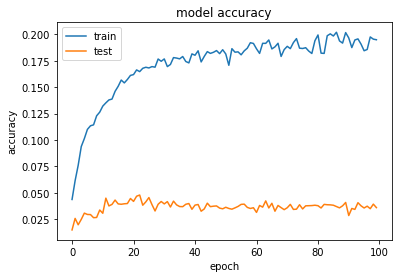

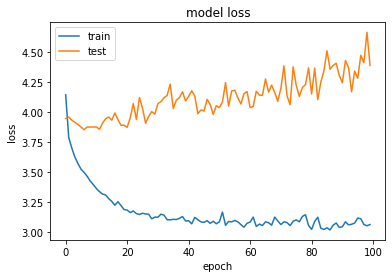

In [38]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

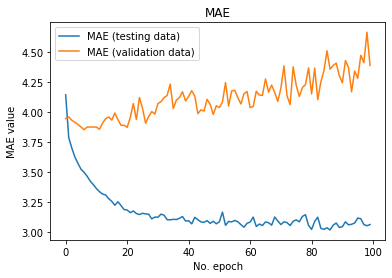

In [39]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

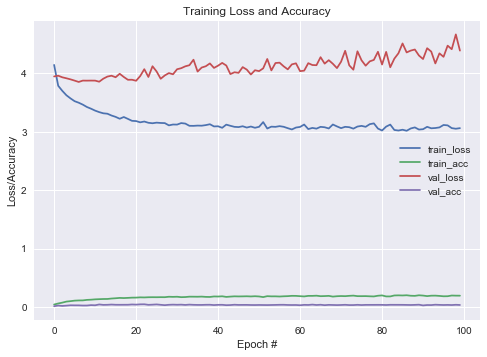

In [40]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochNASNetMobile_OF.png')
plt.close()